Using matplotlib backend: TkAgg
1278


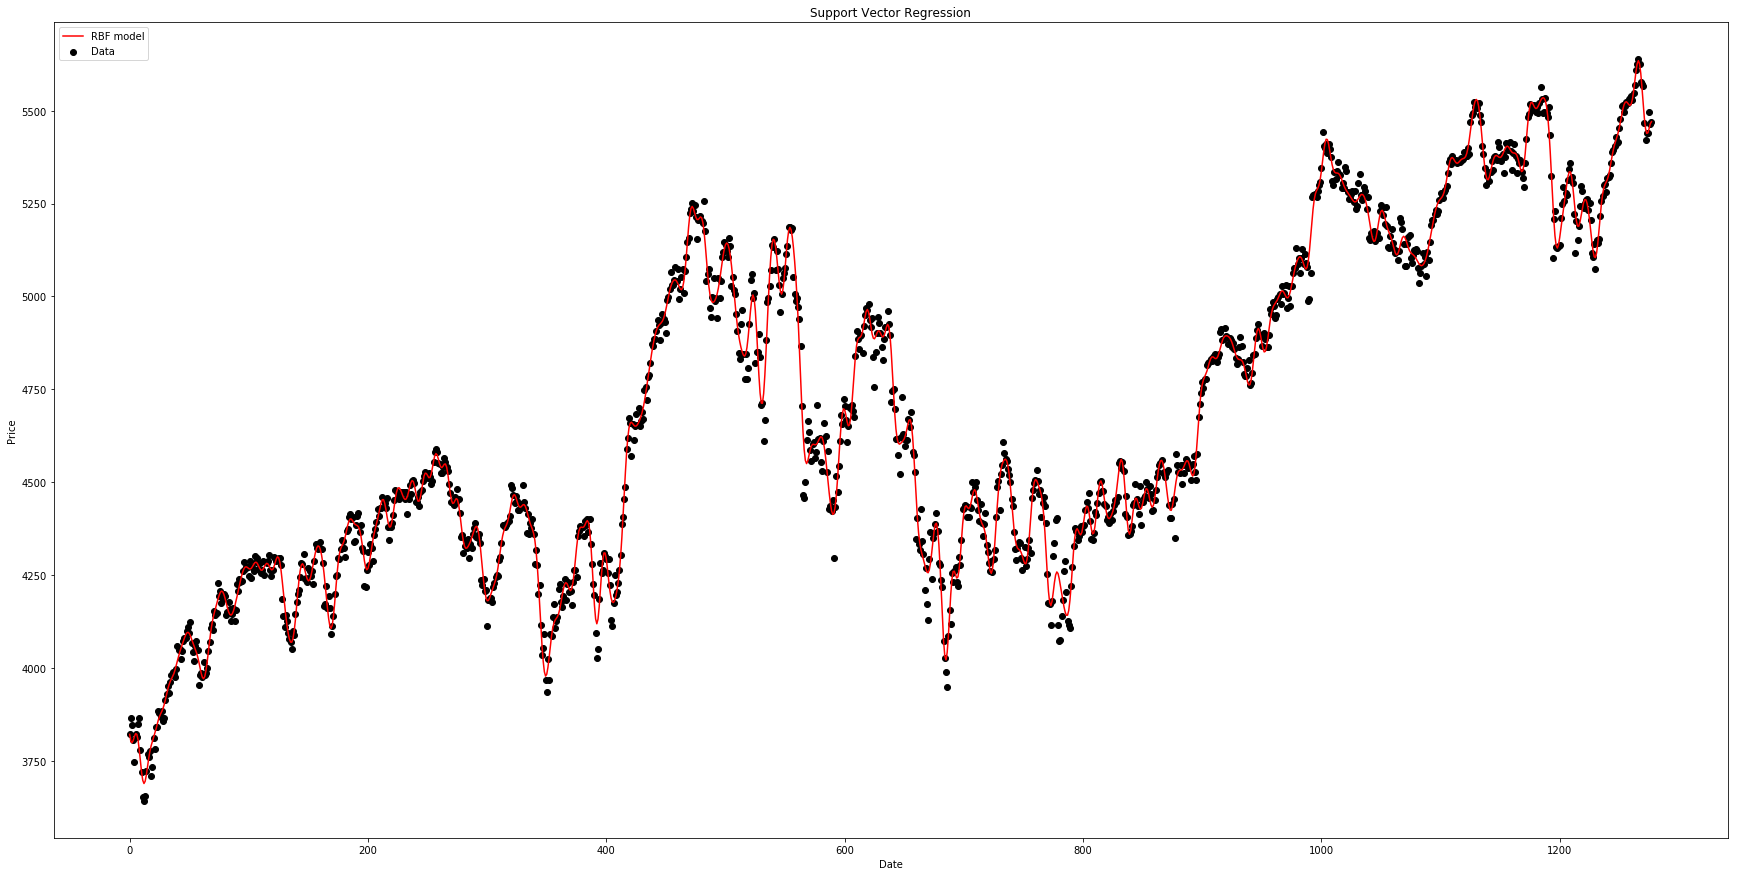

1278
5460.75196507237


In [43]:
# SVR
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30.0, 15.0)

import csv
import numpy as np
from sklearn.svm import SVR


dates = []
real_dates = []
prices = []

i = 0

def read_data(filename):
    global i
    i = 0
    with open(filename, 'r') as csvFile:
        csvFileReader = csv.reader(csvFile)
        next(csvFileReader)
        for row in csvFileReader:
            real_dates.append(row[0])
            dates.append(i)
            prices.append(float(row[1]))
            i = i+1
        print(i)
    return

def price_prediction_model(dates, prices, x):
    dates = np.reshape(dates, (len(dates),1))
    svr_rbf = SVR(kernel='rbf',C=1e4, gamma = 0.01464)
        
    svr_rbf.fit(dates,prices)
    
    plt.scatter(dates, prices, color='black', label='Data')
    plt.plot(dates, svr_rbf.predict(dates), color='red', label='RBF model')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.savefig('test.png', bbox_inches='tight')
    plt.show()
    return svr_rbf.predict(x)[0] 

read_data('CAC40_5Y.csv')

predicted_price = price_prediction_model(dates, prices, i)

print(i)
print(predicted_price)
#SVM not very good at price prediction with 1YR data set
#SVM not very good at price prediction with 5YR data set


In [1]:

"""
NEAT evloving a TraderGenome able to buy/sell/hodl fit for maximum returns
Strategy :  if output in :
                - ]-1, -0.33[ then sell
                - [-0.33, 0.33] then hodl
                - ]0.33, 1[ then buy
"""

from __future__ import print_function
import os
import neat
import visualize
import csv
import math
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


# custom gene with buy_count,sell_count and hodl_count
class TraderGenome(neat.DefaultGenome):
    def __init__(self, key):
        super().__init__(key)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def configure_new(self, config):
        super().configure_new(config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def configure_crossover(self, genome1, genome2, config):
        super().configure_crossover(genome1, genome2, config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def mutate(self, config):
        super().mutate(config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def __str__(self):
        return "buy_count: {0}, sell_count: {1}, hodl_count: {2}\n{3}".format(self.buy_count,self.sell_count,self.hodl_count, super().__str__())



# Date, Open, High, Low, Close, Volume
# training data of CAC40 from 2005-06-13 till 2017-06-13
input_training_data = []

# training data of CAC40 from 2017-06-14 till 2018-06-11
input_testing_data = []

# 1 -> buy
# -1 -> sell
# 0 -> hodl
def decide(res):
    if (res > 0.33):
        return 1.0
    elif (res < -0.33):
        return -1.0
    else:
        return 0.0

def normalize_data(data_array):
    data_norm = []
    minx = min(data_array)
    maxx = max(data_array)
    for data in data_array:
        data_norm.append(2*((data-minx)/(maxx-minx))-1)
    return data_norm, minx, maxx

def load_data_from_csv(filename):
    data = []
    data_open = []
    data_high = []
    data_low = []
    data_close = []
    data_volume = []
    with open(filename, 'r') as File:  
        reader = csv.reader(File)
        for row in reader:
            data.append((round(float(row[1]),2),round(float(row[2]),2),round(float(row[3]),2),round(float(row[4]),2),round(float(row[5]),2)))
            data_open.append(round(float(row[1]),2))
            data_high.append(round(float(row[2]),2))
            data_low.append(round(float(row[3]),2))
            data_close.append(round(float(row[4]),2))
            data_volume.append(round(float(row[5]),2))
    return data, data_open,data_high,data_low,data_close,data_volume
            
    
def combine_arrays(arr1,arr2,arr3,arr4,arr5,):
    index = len(arr1)
    output = []
    for i in range(0,index):
        output.append((arr1[i],arr2[i],arr3[i],arr4[i],arr5[i]))
    return output


input_training_data,input_training_data_open,input_training_data_high,input_training_data_low,input_training_data_close,input_training_data_volume = load_data_from_csv('CAC40_2005_2017.csv')
input_testing_data,input_testing_data_open,input_testing_data_high,input_testing_data_low,input_testing_data_close,input_testing_data_volume = load_data_from_csv('CAC40_2017_2018.csv')


input_training_data_open_norm, input_training_data_open_minx, input_training_data_open_maxx = normalize_data(input_training_data_open)
input_training_data_high_norm, input_training_data_high_minx, input_training_data_high_maxx = normalize_data(input_training_data_high)
input_training_data_low_norm, input_training_data_low_minx, input_training_data_low_maxx = normalize_data(input_training_data_low)
input_training_data_close_norm, input_training_data_close_minx, input_training_data_close_maxx = normalize_data(input_training_data_close)
input_training_data_volume_norm, input_training_data_volume_minx, input_training_data_volume_maxx = normalize_data(input_training_data_volume)


input_testing_data_open_norm, input_testing_data_open_minx, input_testing_data_open_maxx = normalize_data(input_testing_data_open)
input_testing_data_high_norm, input_testing_data_high_minx, input_testing_data_high_maxx = normalize_data(input_testing_data_high)
input_testing_data_low_norm, input_testing_data_low_minx, input_testing_data_low_maxx = normalize_data(input_testing_data_low)
input_testing_data_close_norm, input_testing_data_close_minx, input_testing_data_close_maxx = normalize_data(input_testing_data_close)
input_testing_data_volume_norm, input_testing_data_volume_minx, input_testing_data_volume_maxx = normalize_data(input_testing_data_volume)


    
input_training_data_norm = combine_arrays(input_training_data_open_norm,
                                          input_training_data_high_norm,
                                          input_training_data_low_norm,
                                          input_training_data_close_norm,
                                          input_training_data_volume_norm)

input_testing_data_norm = combine_arrays(input_testing_data_open_norm,
                                          input_testing_data_high_norm,
                                          input_testing_data_low_norm,
                                          input_testing_data_close_norm,
                                          input_testing_data_volume_norm)


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        money = 100000.0
        genome.fitness = 0
        shares = 0
        net = neat.nn.RecurrentNetwork.create(genome, config)
        size = len(input_training_data)
        genome.buy_count = 0
        genome.sell_count = 0
        genome.hodl_count = 0
        for i, input_data in enumerate(input_training_data_norm):
            if (i < size-1):
                #input_data = (input_data) + (shares,money,)
                output = net.activate(input_data)
                decision = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares > 0):
                    shares = shares-1
                    money = money + input_training_data[i+1][0] #Sell on market open
                    genome.sell_count = genome.sell_count+1
                
                elif (decision == 1 and money > input_training_data[i+1][0]):
                    shares = shares+1
                    money = money - input_training_data[i+1][0] #Buy on market open
                    genome.buy_count = genome.buy_count+1
                else: 
                    genome.hodl_count = genome.hodl_count+1
                    
        genome.fitness = ((money + shares*input_training_data[size-1][0]) - 100000.0)/1000.0 #returns in %
        if(genome.buy_count == 0 or genome.sell_count == 0):
            genome.fitness = genome.fitness - 20
        if(genome.hodl_count > genome.sell_count + genome.buy_count):
            op_sum = genome.sell_count + genome.buy_count
            penality = 80
            if (op_sum != 0):
                penality == 30*genome.hodl_count/(op_sum)

            genome.fitness -= math.floor(penality)


                
#EXECUSTION            
local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-tradergenome')
# Load configuration.
config = neat.Config(TraderGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Run for up to X generations.
winner = p.run(eval_genomes, 200)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

print('\nOutput:')
winner_net = neat.nn.RecurrentNetwork.create(winner, config)

node_names = {-1:'Open', -2: 'High',-3: 'Low',-4: 'Close',-5: 'Volume', 0:'Decide'}
visualize.draw_net(config, winner, True, node_names=node_names)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

"""
Testing best TraderGenome 2017-2018
"""

def test_best(input_test,input_test_norm):
    capital = 100000.0
    shares = 0
    size = len(input_test)
    buy_count = 0
    sell_count = 0
    hodl_count = 0
    for i, input_data in enumerate(input_test_norm):
        if (i < size-1):
                #input_data = (input_data) + (shares,capital,)
                output = winner_net.activate(input_data)
                decision = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares > 0):
                    shares = shares-1
                    capital = capital + input_test[i+1][0] #Sell on market open
                    sell_count = sell_count+1

                elif (decision == 1 and capital > input_test[i+1][0]):
                    shares = shares+1
                    capital = capital - input_test[i+1][0] #Buy on market open
                    buy_count = buy_count+1
                else: 
                    hodl_count = hodl_count+1
    print('Money: {!r}, Shares: {!r}\n'.format(capital,shares))
    print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))        

print('2017-2018 test')
test_best(input_testing_data,input_testing_data_norm)
    
"""
Testing TraderGenome 2005-2018
"""

input_testing_data_norm_full = input_training_data_norm + input_testing_data_norm

input_testing_data_full = input_training_data + input_testing_data

print('2005-2018 test')
test_best(input_testing_data_full,input_testing_data_norm_full)




 ****** Running generation 0 ****** 

Population's average fitness: -55.00646 stdev: 42.07047
Best fitness: 71.24913 - size: (4, 22) - species 3 - id 119
Average adjusted fitness: 0.283
Mean genetic distance 3.371, standard deviation 0.383
Population of 300 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   108     12.3    0.366     0
     2    0     3      2.7    0.166     0
     3    0    61     71.2    0.341     0
     4    0    14     70.5    0.404     0
     5    0    11    -57.1    0.242     0
     6    0    18     65.6    0.329     0
     7    0    51     17.6    0.285     0
     8    0     6    -76.0    0.232     0
     9    0    11     35.7    0.334     0
    10    0     3   -100.0    0.107     0
    11    0     6   -100.0    0.107     0
    12    0     2     14.4    0.663     0
    13    0     6   -100.0    0.107     0
Total extinctions: 0
Generation time: 14.892 sec

 ****** Running generation 1 ****** 



Population's average fitness: -21.58205 stdev: 55.56092
Best fitness: 119.07992 - size: (5, 22) - species 8 - id 350
Average adjusted fitness: 0.393
Mean genetic distance 2.910, standard deviation 0.588
Population of 302 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    9    20     46.4    0.471     8
     2    9     9     -0.8    0.207     9
     3    9    13     60.3    0.338     7
     4    9    11     91.8    0.502     3
     5    9    27     86.7    0.419     6
     6    9    17     85.6    0.467     0
     7    9    18     65.1    0.354     7
     8    9    12    119.1    0.448     0
     9    9    94      3.9    0.434     2
    10    9    19     73.1    0.381     4
    11    9    23     89.8    0.379     1
    12    9    21     70.3    0.346     1
    13    9    18     82.1    0.368     0
Total extinctions: 0
Generation time: 14.445 sec (15.045 average)
Saving checkpoint to neat-checkpoint-9

 ****** Running gene

Population's average fitness: -11.54622 stdev: 58.65640
Best fitness: 119.07992 - size: (5, 22) - species 1 - id 350
Average adjusted fitness: 0.414
Mean genetic distance 2.899, standard deviation 0.598
Population of 298 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18     5    119.1    0.310    17
     2   18    94     66.6    0.453     1
     3   18    21    104.6    0.435    16
     4   18    21     91.8    0.448    12
     5   18    21     86.7    0.385    15
     6   18    20     92.5    0.545     5
     7   18     4    -76.0    0.139     7
     8   18    19     85.9    0.538     9
     9   18    19     76.9    0.409    11
    10   18    17    100.0    0.447     0
    11   18    21     89.8    0.347    10
    12   18    18     76.0    0.445     6
    13   18    18     89.3    0.484     7
Total extinctions: 0
Generation time: 16.328 sec (15.146 average)

 ****** Running generation 19 ****** 

Population's average

Population's average fitness: -11.92007 stdev: 58.65356
Best fitness: 119.07992 - size: (5, 22) - species 7 - id 350
Average adjusted fitness: 0.415
Mean genetic distance 2.939, standard deviation 0.588
Population of 297 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   27     9     65.5    0.274    26
     2   27    23    104.4    0.444     8
     3   27    19    104.6    0.368    25
     4   27    21     91.8    0.484    21
     5   27    23     87.9    0.388     4
     6   27    25     92.5    0.549    14
     7   27   103    119.1    0.465    16
     8   27     3     88.6    0.507    18
     9   27     7    103.1    0.328    20
    10   27     2     62.0    0.316     9
    11   27    19     89.8    0.383    19
    12   27    16     76.0    0.359    15
    13   27    27     91.0    0.531     4
Total extinctions: 0
Generation time: 15.283 sec (15.149 average)

 ****** Running generation 28 ****** 

Population's average

Population's average fitness: -9.97112 stdev: 57.93529
Best fitness: 128.01616 - size: (7, 24) - species 9 - id 8800

Species 4 with 30 members is stagnated: removing it
Average adjusted fitness: 0.426
Mean genetic distance 2.839, standard deviation 0.702
Population of 301 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   36    23     92.6    0.406     1
     3   36    21    104.6    0.375    34
     5   36    27     87.9    0.469    13
     6   36    40     92.5    0.481    23
     7   36    18     93.1    0.504     5
     8   36    22     84.4    0.512    27
     9   36    45    128.0    0.414     3
    10   36    26     55.5    0.352    18
    11   36    24     89.8    0.364    28
    12   36    23     76.0    0.350    24
    13   36    32     94.4    0.460     1
Total extinctions: 0
Generation time: 17.960 sec (15.901 average)

 ****** Running generation 37 ****** 

Population's average fitness: -11.82902 stdev: 58.2

Population's average fitness: -14.10513 stdev: 53.07848
Best fitness: 128.01616 - size: (7, 24) - species 7 - id 8800
Average adjusted fitness: 0.399
Mean genetic distance 2.688, standard deviation 0.678
Population of 301 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   46    71    123.0    0.362    11
     5   46    45     87.9    0.355    23
     7   46    81    128.0    0.467    15
     9   46     2    111.5    0.382    13
    10   46    44     91.3    0.370    28
    13   46    58     95.7    0.456     2
Total extinctions: 0
Generation time: 17.270 sec (16.652 average)

 ****** Running generation 47 ****** 

Population's average fitness: -11.06568 stdev: 52.71253
Best fitness: 128.01616 - size: (7, 24) - species 7 - id 8800
Average adjusted fitness: 0.445
Mean genetic distance 2.630, standard deviation 0.711
Population of 299 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  

Population's average fitness: -17.38522 stdev: 54.85586
Best fitness: 128.01616 - size: (7, 24) - species 7 - id 8800
Average adjusted fitness: 0.402
Mean genetic distance 2.929, standard deviation 0.566
Population of 301 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   59    86     92.7    0.399    11
     5   59    58     66.0    0.369    10
     7   59    60    128.0    0.400    28
     9   59    32    123.3    0.418    26
    13   59    65     95.7    0.426    15
Total extinctions: 0
Generation time: 17.655 sec (15.961 average)
Saving checkpoint to neat-checkpoint-59

 ****** Running generation 60 ****** 

Population's average fitness: -14.54797 stdev: 55.24693
Best fitness: 128.01616 - size: (7, 24) - species 7 - id 8800
Average adjusted fitness: 0.380
Mean genetic distance 2.993, standard deviation 0.563
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ==

Population's average fitness: 2.63240 stdev: 52.36129
Best fitness: 128.01616 - size: (7, 24) - species 14 - id 8800
Average adjusted fitness: 0.462
Mean genetic distance 3.001, standard deviation 0.525
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   73    62     85.6    0.524    25
     5   73   133    113.0    0.475    24
    13   73    42     83.6    0.439     9
    14   10    63    128.0    0.409     0
Total extinctions: 0
Generation time: 13.834 sec (16.622 average)

 ****** Running generation 74 ****** 

Population's average fitness: 1.78288 stdev: 53.13972
Best fitness: 128.01616 - size: (7, 24) - species 14 - id 8800
Average adjusted fitness: 0.428
Mean genetic distance 2.985, standard deviation 0.540
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   74    43     85.6    0.460    26
     5   74    25    113.0    

Population's average fitness: 9.58588 stdev: 54.20871
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.492
Mean genetic distance 3.052, standard deviation 0.713
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13   87    94     93.4    0.472    23
    14   24    69    117.9    0.416    14
    15    9    68    128.0    0.527     7
    16    9    68     91.2    0.553     0
Total extinctions: 0
Generation time: 16.514 sec (17.350 average)

 ****** Running generation 88 ****** 

Population's average fitness: 15.20431 stdev: 55.44670
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.504
Mean genetic distance 3.093, standard deviation 0.639
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13   88    71     93.4    0.520    24
    14   25    67    117.9   

Population's average fitness: 14.03175 stdev: 56.33044
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.510
Mean genetic distance 3.084, standard deviation 0.647
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  101    70     94.6    0.437    37
    14   38    83    117.9    0.535    28
    15   23    68    128.0    0.514    21
    16   23    79     91.6    0.554     4
Total extinctions: 0
Generation time: 18.393 sec (18.108 average)

 ****** Running generation 102 ****** 

Population's average fitness: 13.09329 stdev: 55.45013
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.522
Mean genetic distance 3.092, standard deviation 0.627
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  102    71     94.6    0.498    38
    14   39    82    117.9 


 ****** Running generation 115 ****** 

Population's average fitness: 11.81428 stdev: 55.71613
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.502
Mean genetic distance 3.000, standard deviation 0.644
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  115    79     94.6    0.516    51
    14   52    68    117.9    0.403    42
    15   37    76    128.0    0.569    35
    16   37    78     91.6    0.519    18
Total extinctions: 0
Generation time: 24.669 sec (23.129 average)

 ****** Running generation 116 ****** 

Population's average fitness: 11.04640 stdev: 57.61441
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.491
Mean genetic distance 3.027, standard deviation 0.636
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  116    78     94.6  

Population's average fitness: 20.13002 stdev: 54.46557
Best fitness: 128.65353 - size: (7, 24) - species 15 - id 33651
Average adjusted fitness: 0.526
Mean genetic distance 3.080, standard deviation 0.582
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  129    98     99.1    0.538    65
    14   66   108    117.9    0.508    56
    15   51    94    128.7    0.533    12
Total extinctions: 0
Generation time: 16.253 sec (19.765 average)
Saving checkpoint to neat-checkpoint-129

 ****** Running generation 130 ****** 

Population's average fitness: 16.67937 stdev: 54.61986
Best fitness: 128.65353 - size: (7, 24) - species 15 - id 33651
Average adjusted fitness: 0.514
Mean genetic distance 3.118, standard deviation 0.576
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  130    91     99.1    0.521    66
    14   67   103    117.9

Population's average fitness: 18.68233 stdev: 54.02751
Best fitness: 133.83587 - size: (18, 31) - species 13 - id 39632
Average adjusted fitness: 0.514
Mean genetic distance 3.010, standard deviation 0.639
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  144    92    133.8    0.535     6
    14   81   108    117.9    0.443    71
    15   66   101    128.7    0.563    27
Total extinctions: 0
Generation time: 16.071 sec (16.028 average)
Saving checkpoint to neat-checkpoint-144

 ****** Running generation 145 ****** 

Population's average fitness: 27.57522 stdev: 50.91307
Best fitness: 133.83587 - size: (18, 31) - species 13 - id 39632
Average adjusted fitness: 0.547
Mean genetic distance 3.024, standard deviation 0.619
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  145    86    133.8    0.535     7
    14   82   113    117

Population's average fitness: 12.40400 stdev: 56.27836
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.424
Mean genetic distance 3.079, standard deviation 0.563
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  159   103    133.8    0.482    21
    14   96    76    156.0    0.315     3
    15   81   120    128.7    0.475    42
Total extinctions: 0
Generation time: 20.061 sec (16.415 average)
Saving checkpoint to neat-checkpoint-159

 ****** Running generation 160 ****** 

Population's average fitness: 17.78233 stdev: 60.75208
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.448
Mean genetic distance 3.025, standard deviation 0.639
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  160   106    133.8    0.487    22
    14   97   131    156

Population's average fitness: 30.93189 stdev: 54.58631
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.517
Mean genetic distance 3.190, standard deviation 0.588
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  174    78    133.8    0.522    36
    14  111    97    156.0    0.554    18
    15   96   125    128.7    0.474    57
Total extinctions: 0
Generation time: 17.414 sec (16.760 average)
Saving checkpoint to neat-checkpoint-174

 ****** Running generation 175 ****** 

Population's average fitness: 27.47026 stdev: 52.97835
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.514
Mean genetic distance 3.182, standard deviation 0.593
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  175    74    133.8    0.507    37
    14  112   107    156

Population's average fitness: 27.14611 stdev: 56.53190
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.522
Mean genetic distance 3.091, standard deviation 0.664
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  189    91    133.8    0.523    51
    14  126    69    156.0    0.562    33
    15  111   140    128.7    0.481    72
Total extinctions: 0
Generation time: 17.714 sec (18.882 average)
Saving checkpoint to neat-checkpoint-189

 ****** Running generation 190 ****** 

Population's average fitness: 21.62156 stdev: 56.88084
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.489
Mean genetic distance 3.064, standard deviation 0.724
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  190    88    133.8    0.447    52
    14  127    72    156

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

2017-2018 test
Money: 27400.259999999984, Shares: 14

buy_count: 105, sell_count: 91, hodl_count: 56

2005-2018 test
Money: 28990.259999999947, Shares: 41

buy_count: 1120, sell_count: 1079, hodl_count: 1119



In [1]:


from __future__ import print_function
import os
import neat
import visualize
import csv
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-tradergenome')
# Load configuration.
config = neat.Config(TraderGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)




p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-673')
winner = p.run(eval_genomes, 100)

winner_net = neat.nn.RecurrentNetwork.create(winner, config)


"""
Testing best TraderGenome 2017-2018
"""

def test_best(input_test,input_test_norm):
    capital = 100000.0
    shares = 0
    size = len(input_test)
    buy_count = 0
    sell_count = 0
    hodl_count = 0
    for i, input_data in enumerate(input_test_norm):
        if (i < size-1):
                #input_data = (input_data) + (shares,capital,)
                output = winner_net.activate(input_data)
                decision = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                string_dec = ''
                if (decision == -1 and shares > 0):
                    shares = shares-1
                    capital = capital + input_test[i+1][0] #Sell on market open
                    sell_count = sell_count+1
                    string_dec = 'Sell'

                elif (decision == 1 and capital > input_test[i+1][0]):
                    shares = shares+1
                    capital = capital - input_test[i+1][0] #Buy on market open
                    buy_count = buy_count+1
                    string_dec = 'Buy'
                else: 
                    hodl_count = hodl_count+1
                    string_dec = 'Hodl'
                
               # print('{!r}->{!s}: (Money: {!r}, Shares: {!r})'.format(i,string_dec,capital,shares))
    print('Money: {!r}, Shares: {!r}\n'.format(capital,shares))
    print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))        


print('2017-2018 test')
test_best(input_testing_data,input_testing_data_norm)
    
"""
Testing TraderGenome 2005-2018
"""

input_testing_data_norm_full = input_training_data_norm + input_testing_data_norm

input_testing_data_full = input_training_data + input_testing_data

print('2005-2018 test')
test_best(input_testing_data_full,input_testing_data_norm_full)


NameError: name 'TraderGenome' is not defined


 ****** Running generation 0 ****** 



c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in arctanh


Population's average fitness: -6401.66612 stdev: 3120.92923
Best fitness: 79.42722 - size: (15, 127) - species 1 - id 242
Average adjusted fitness: 0.431
Mean genetic distance 4.167, standard deviation 0.387
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    74     79.4    0.493     0
     2    0    62     19.2    0.459     0
     3    0   114     71.3    0.456     0
     4    0    26  -3858.2    0.444     0
     5    0    24  -4763.5    0.305     0
Total extinctions: 0
Generation time: 51.107 sec

 ****** Running generation 1 ****** 

Population's average fitness: -5020.78616 stdev: 3025.99747
Best fitness: 79.42722 - size: (15, 127) - species 3 - id 242
Average adjusted fitness: 0.563
Mean genetic distance 4.053, standard deviation 0.588
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1     7     45.8    0.642   

Population's average fitness: -3607.86848 stdev: 3102.58956
Best fitness: 119.04370 - size: (16, 128) - species 3 - id 2542
Average adjusted fitness: 0.701
Mean genetic distance 3.626, standard deviation 0.947
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   13    58     91.0    0.681     8
     2   13    74     18.1    0.740     5
     3   13    57    119.0    0.681     3
     4   13    85    106.5    0.772     2
     5   13    26     77.7    0.630     2
Total extinctions: 0
Generation time: 53.355 sec (51.724 average)

 ****** Running generation 14 ****** 

Population's average fitness: -3660.35197 stdev: 3523.89626
Best fitness: 119.04370 - size: (16, 128) - species 3 - id 2542
Average adjusted fitness: 0.686
Mean genetic distance 3.677, standard deviation 0.883
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   14    5

Population's average fitness: -3626.62484 stdev: 3561.89416
Best fitness: 119.04370 - size: (16, 128) - species 3 - id 2542
Average adjusted fitness: 0.693
Mean genetic distance 3.627, standard deviation 1.010
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   26    56    101.7    0.692    10
     2   26    50     61.9    0.655    18
     3   26    72    119.0    0.722    16
     4   26    56    106.5    0.623    15
     5   26    66    110.6    0.775    15
Total extinctions: 0
Generation time: 52.258 sec (51.678 average)

 ****** Running generation 27 ****** 

Population's average fitness: -3137.59675 stdev: 3228.79101
Best fitness: 119.04370 - size: (16, 128) - species 3 - id 2542
Average adjusted fitness: 0.733
Mean genetic distance 3.535, standard deviation 1.077
Population of 299 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   27    3

Population's average fitness: -3080.35450 stdev: 3394.51318
Best fitness: 119.04370 - size: (16, 128) - species 3 - id 2542
Average adjusted fitness: 0.739
Mean genetic distance 3.392, standard deviation 1.060
Population of 299 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   39    58    114.2    0.708     5
     2   39    60    110.6    0.737    31
     3   39    66    119.0    0.840    29
     4   39    59    107.7    0.742     6
     5   39    56    101.4    0.669    28
Total extinctions: 0
Generation time: 58.711 sec (57.106 average)

 ****** Running generation 40 ****** 

Population's average fitness: -3389.81389 stdev: 3615.15540
Best fitness: 119.04370 - size: (16, 128) - species 3 - id 2542
Average adjusted fitness: 0.713
Mean genetic distance 3.415, standard deviation 1.054
Population of 299 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   40    5

Mean genetic distance 3.590, standard deviation 0.872
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   52    76    114.2    0.729    18
     2   52    72    110.6    0.718    44
     3   52    76    121.8    0.735     2
     4   52    76    107.7    0.783    19
Total extinctions: 0
Generation time: 59.341 sec (60.491 average)
Saving checkpoint to neat-checkpoint-52

 ****** Running generation 53 ****** 

Population's average fitness: -3225.60402 stdev: 3448.18639
Best fitness: 121.78626 - size: (17, 128) - species 3 - id 14746
Average adjusted fitness: 0.729
Mean genetic distance 3.561, standard deviation 0.862
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   53    78    114.2    0.784    19
     2   53    73    110.6    0.716    45
     3   53    75    121.8    0.720     3
     4   53    74    107.7    0.696    20
Total

Population's average fitness: -3046.08126 stdev: 3488.20529
Best fitness: 121.78626 - size: (17, 128) - species 3 - id 14746
Average adjusted fitness: 0.741
Mean genetic distance 3.574, standard deviation 0.903
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   66    75    114.2    0.751    32
     2   66    71    110.6    0.677    58
     3   66    85    121.8    0.853    16
     4   66    70    108.2    0.681     4
Total extinctions: 0
Generation time: 55.933 sec (59.663 average)

 ****** Running generation 67 ****** 

Population's average fitness: -3284.33733 stdev: 3648.36840
Best fitness: 121.78626 - size: (17, 128) - species 3 - id 14746

Species 2 with 71 members is stagnated: removing it
Average adjusted fitness: 0.716
Mean genetic distance 3.393, standard deviation 1.018
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   

Mean genetic distance 3.358, standard deviation 0.952
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   80   108    114.2    0.802    46
     3   80    99    145.5    0.724    12
     4   80    94    116.8    0.669    13
Total extinctions: 0
Generation time: 77.948 sec (74.895 average)
Saving checkpoint to neat-checkpoint-80

 ****** Running generation 81 ****** 

Population's average fitness: -2845.46584 stdev: 3708.61615
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.758
Mean genetic distance 3.383, standard deviation 0.954
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   81   106    114.2    0.789    47
     3   81    97    145.5    0.725    13
     4   81    97    116.8    0.760    14
Total extinctions: 0
Generation time: 79.768 sec (75.062 average)

 ****** Running genera

Population's average fitness: -2667.03268 stdev: 3725.57963
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.772
Mean genetic distance 3.330, standard deviation 0.915
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   95   101    117.8    0.780     2
     3   95   105    145.5    0.799    27
     4   95    95    116.8    0.735    28
Total extinctions: 0
Generation time: 70.350 sec (69.808 average)

 ****** Running generation 96 ****** 

Population's average fitness: -3102.36660 stdev: 3767.60429
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.735
Mean genetic distance 3.337, standard deviation 0.881
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   96   102    117.8    0.746     3
     3   96   108    145.5    0.812    28
     4   96   

Mean genetic distance 3.359, standard deviation 0.841
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  109    99    117.8    0.772    16
     3  109   101    145.5    0.791    41
     4  109   101    116.8    0.798    42
Total extinctions: 0
Generation time: 62.890 sec (70.547 average)

 ****** Running generation 110 ****** 

Population's average fitness: -3531.08008 stdev: 4102.76497
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.703
Mean genetic distance 3.302, standard deviation 0.845
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  110    96    117.8    0.650    17
     3  110   103    145.5    0.737    42
     4  110   102    116.8    0.722    43
Total extinctions: 0
Generation time: 61.810 sec (69.919 average)

 ****** Running generation 111 ****** 

Population's average 


Population's average fitness: -3579.73750 stdev: 4297.62435
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.699
Mean genetic distance 3.324, standard deviation 0.908
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  124    96    117.8    0.672    31
     3  124   101    145.5    0.685    56
     4  124   104    120.3    0.739     2
Total extinctions: 0
Generation time: 62.909 sec (62.727 average)

 ****** Running generation 125 ****** 

Population's average fitness: -3213.93226 stdev: 3986.22660
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.730
Mean genetic distance 3.304, standard deviation 0.946
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  125   100    117.8    0.764    32
     3  125   100    145.5    0.718    57
     4  125 


Population's average fitness: -3007.54264 stdev: 4002.61512
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.746
Mean genetic distance 3.317, standard deviation 0.793
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  139   103    117.8    0.755    46
     3  139   101    145.5    0.789    71
     4  139    97    120.3    0.694    17
Total extinctions: 0
Generation time: 59.566 sec (60.537 average)

 ****** Running generation 140 ****** 

Population's average fitness: -2618.12078 stdev: 3683.91528
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.776
Mean genetic distance 3.344, standard deviation 0.796
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  140   103    117.8    0.806    47
     3  140   101    145.5    0.785    72
     4  140 


 ****** Running generation 154 ****** 

Population's average fitness: -3069.65685 stdev: 3688.52684
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.741
Mean genetic distance 3.289, standard deviation 0.757
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  154    98    117.8    0.718    61
     3  154   103    145.5    0.785    86
     4  154    99    120.3    0.719    32
Total extinctions: 0
Generation time: 65.317 sec (63.284 average)

 ****** Running generation 155 ****** 

Population's average fitness: -3015.30186 stdev: 3901.73562
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.745
Mean genetic distance 3.251, standard deviation 0.751
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  155   101    117.8    0.769    62
     3  155   

Mean genetic distance 3.299, standard deviation 0.834
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  168    96    117.8    0.735    75
     3  168   106    145.5    0.833   100
     4  168    98    120.3    0.739    46
Total extinctions: 0
Generation time: 62.169 sec (62.852 average)
Saving checkpoint to neat-checkpoint-168

 ****** Running generation 169 ****** 

Population's average fitness: -2787.01155 stdev: 3800.52379
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.763
Mean genetic distance 3.308, standard deviation 0.815
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  169    98    117.8    0.757    76
     3  169   104    145.5    0.773   101
     4  169    99    120.3    0.759    47
Total extinctions: 0
Generation time: 61.625 sec (62.547 average)

 ****** Running gene

Population's average fitness: -2298.07494 stdev: 3592.86845
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.802
Mean genetic distance 3.217, standard deviation 0.747
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  183   102    117.8    0.815    90
     3  183    96    145.5    0.773   115
     4  183   102    120.3    0.818    61
Total extinctions: 0
Generation time: 60.646 sec (62.699 average)
Saving checkpoint to neat-checkpoint-183

 ****** Running generation 184 ****** 

Population's average fitness: -2252.94065 stdev: 3159.40238
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.807
Mean genetic distance 3.229, standard deviation 0.757
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  184    99    117.8    0.772    91
     3  184   

Mean genetic distance 3.127, standard deviation 0.709
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  197    96    117.8    0.741   104
     3  197   101    145.5    0.749   129
     4  197   103    120.3    0.780    75
Total extinctions: 0
Generation time: 59.903 sec (61.235 average)

 ****** Running generation 198 ****** 

Population's average fitness: -2633.67979 stdev: 3917.15237
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.776
Mean genetic distance 3.178, standard deviation 0.681
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  198    97    117.8    0.764   105
     3  198   104    145.5    0.808   130
     4  198    99    120.3    0.755    76
Total extinctions: 0
Generation time: 59.353 sec (60.854 average)
Saving checkpoint to neat-checkpoint-198

 ****** Running gene

Population's average fitness: -2284.77277 stdev: 3636.89264
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.803
Mean genetic distance 3.214, standard deviation 0.884
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  212   164    117.8    0.821   119
     3  212    43    145.5    0.788   144
     4  212    92    120.3    0.802    90
Total extinctions: 0
Generation time: 61.316 sec (59.972 average)

 ****** Running generation 213 ****** 

Population's average fitness: -2624.62140 stdev: 3777.41833
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.752
Mean genetic distance 3.240, standard deviation 0.950
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  213   147    117.8    0.827   120
     3  213    68    145.5    0.711   145
     4  213  

Mean genetic distance 3.096, standard deviation 1.024
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  226    98    117.8    0.753   133
     3  226    90    145.5    0.736   158
     4  226   112     97.8    0.768    12
Total extinctions: 0
Generation time: 57.438 sec (64.223 average)

 ****** Running generation 227 ****** 

Population's average fitness: -3405.16707 stdev: 3910.91160
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.714
Mean genetic distance 3.096, standard deviation 0.995
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  227    99    117.8    0.740   134
     3  227    93    145.5    0.698   159
     4  227   108     97.8    0.702    13
Total extinctions: 0
Generation time: 58.083 sec (62.616 average)

 ****** Running generation 228 ****** 

Population's average 

Population's average fitness: -3138.48154 stdev: 3998.16896
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.733
Mean genetic distance 3.260, standard deviation 0.800
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  241   101    117.8    0.805   148
     3  241    89    145.5    0.642   173
     4  241   110     97.8    0.752    27
Total extinctions: 0
Generation time: 56.159 sec (57.983 average)

 ****** Running generation 242 ****** 

Population's average fitness: -2761.43009 stdev: 3770.39091
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.763
Mean genetic distance 3.238, standard deviation 0.807
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  242   101    117.9    0.804     0
     3  242    89    145.5    0.715   174
     4  242  

Mean genetic distance 3.498, standard deviation 0.646
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  255   171    117.9    0.708    13
     3  255    32    145.5    0.777   187
     4  255    98    103.0    0.749    41
Total extinctions: 0
Generation time: 68.487 sec (74.051 average)

 ****** Running generation 256 ****** 

Population's average fitness: -2965.47967 stdev: 4314.41087
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.728
Mean genetic distance 3.492, standard deviation 0.666
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  256   138    117.9    0.772    14
     3  256    63    145.5    0.680   188
     4  256   100    103.0    0.731    42
Total extinctions: 0
Generation time: 67.464 sec (72.877 average)
Saving checkpoint to neat-checkpoint-256

 ****** Running gene

Population's average fitness: -2409.05469 stdev: 3803.61900
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.793
Mean genetic distance 3.431, standard deviation 0.630
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  270   106    117.9    0.794    28
     3  270    85    145.5    0.785   202
     4  270   109    103.0    0.800    56
Total extinctions: 0
Generation time: 63.240 sec (63.600 average)

 ****** Running generation 271 ****** 

Population's average fitness: -3168.49172 stdev: 4126.00535
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.731
Mean genetic distance 3.403, standard deviation 0.663
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  271   104    117.9    0.747    29
     3  271    94    145.5    0.707   203
     4  271  

Mean genetic distance 3.232, standard deviation 0.977
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  284    86    117.9    0.737    42
     3  284    93    145.5    0.757   216
     4  284   121    111.3    0.767    70
Total extinctions: 0
Generation time: 68.385 sec (68.380 average)

 ****** Running generation 285 ****** 

Population's average fitness: -3414.91130 stdev: 4289.88749
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.711
Mean genetic distance 3.264, standard deviation 0.987
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  285    93    117.9    0.712    43
     3  285    87    145.5    0.685   217
     4  285   120    111.3    0.735    71
Total extinctions: 0
Generation time: 64.254 sec (68.451 average)
Saving checkpoint to neat-checkpoint-285

 ****** Running gene

Population's average fitness: -3259.96253 stdev: 4179.49393
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.725
Mean genetic distance 3.261, standard deviation 0.833
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  299   103    117.9    0.770    57
     3  299    91    145.5    0.661   231
     4  299   107    121.9    0.742    85
Total extinctions: 0
Generation time: 78.977 sec (78.266 average)
Saving checkpoint to neat-checkpoint-299

 ****** Running generation 300 ****** 

Population's average fitness: -2674.13070 stdev: 3952.11908
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.775
Mean genetic distance 3.245, standard deviation 0.886
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  300    98    117.9    0.727    58
     3  300   

Mean genetic distance 3.245, standard deviation 0.875
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  313   100    117.9    0.773    71
     3  313   101    145.5    0.810   245
     4  313   100    121.9    0.742    99
Total extinctions: 0
Generation time: 64.916 sec (70.098 average)
Saving checkpoint to neat-checkpoint-313

 ****** Running generation 314 ****** 

Population's average fitness: -2825.21615 stdev: 4077.87517
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.760
Mean genetic distance 3.236, standard deviation 0.865
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  314    99    117.9    0.756    72
     3  314    98    145.5    0.725   246
     4  314   103    121.9    0.800   100
Total extinctions: 0
Generation time: 66.703 sec (66.680 average)

 ****** Running gene


 ****** Running generation 328 ****** 

Population's average fitness: -3009.11382 stdev: 4260.13570
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.746
Mean genetic distance 3.330, standard deviation 0.763
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  328   102    120.1    0.782     6
     3  328    95    145.5    0.678   260
     4  328   103    121.9    0.778   114
Total extinctions: 0
Generation time: 69.409 sec (73.239 average)

 ****** Running generation 329 ****** 

Population's average fitness: -2758.39123 stdev: 3998.32269
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.767
Mean genetic distance 3.366, standard deviation 0.764
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  329   101    120.1    0.772     7
     3  329   

Mean genetic distance 3.157, standard deviation 0.785
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  342    99    120.1    0.780    20
     3  342   100    145.5    0.811   274
     4  342   100    121.9    0.763   128
Total extinctions: 0
Generation time: 78.591 sec (65.176 average)
Saving checkpoint to neat-checkpoint-342

 ****** Running generation 343 ****** 

Population's average fitness: -3464.88198 stdev: 4600.85746
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.709
Mean genetic distance 3.159, standard deviation 0.778
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  343   102    120.1    0.747    21
     3  343    98    145.5    0.677   275
     4  343    99    121.9    0.703   129
Total extinctions: 0
Generation time: 102.089 sec (68.712 average)

 ****** Running gen


 ****** Running generation 357 ****** 

Population's average fitness: -2724.83968 stdev: 4331.97935
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.768
Mean genetic distance 3.277, standard deviation 0.879
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  357   102    120.1    0.806    35
     3  357   103    145.5    0.806   289
     4  357    95    121.9    0.693   143
Total extinctions: 0
Generation time: 66.300 sec (65.003 average)

 ****** Running generation 358 ****** 

Population's average fitness: -3338.26021 stdev: 4558.65511
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.719
Mean genetic distance 3.250, standard deviation 0.916
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  358    99    120.1    0.687    36
     3  358   

Mean genetic distance 3.223, standard deviation 0.781
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  371   107    120.1    0.785    49
     3  371    94    145.5    0.654   303
     4  371    98    121.9    0.696   157
Total extinctions: 0
Generation time: 65.840 sec (64.376 average)
Saving checkpoint to neat-checkpoint-371

 ****** Running generation 372 ****** 

Population's average fitness: -3118.40473 stdev: 4138.33717
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.735
Mean genetic distance 3.223, standard deviation 0.784
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  372   106    120.1    0.773    50
     3  372    93    145.5    0.683   304
     4  372   100    121.9    0.749   158
Total extinctions: 0
Generation time: 65.703 sec (64.354 average)

 ****** Running gene

Population's average fitness: -2850.17728 stdev: 4289.90430
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.757
Mean genetic distance 3.210, standard deviation 0.750
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  386    99    120.1    0.737    64
     3  386    95    145.5    0.733   318
     4  386   106    121.9    0.802   172
Total extinctions: 0
Generation time: 56.869 sec (60.029 average)

 ****** Running generation 387 ****** 

Population's average fitness: -2785.31455 stdev: 4367.93547
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.762
Mean genetic distance 3.247, standard deviation 0.730
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  387   101    120.1    0.786    65
     3  387    93    145.5    0.699   319
     4  387  

Mean genetic distance 3.232, standard deviation 0.691
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  400    99    120.1    0.745    78
     3  400   100    145.5    0.756   332
     4  400   102    121.9    0.780   186
Total extinctions: 0
Generation time: 67.935 sec (77.158 average)

 ****** Running generation 401 ****** 

Population's average fitness: -2637.02070 stdev: 4287.81524
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.776
Mean genetic distance 3.294, standard deviation 0.663
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  401   100    120.1    0.782    79
     3  401   102    145.5    0.823   333
     4  401    99    121.9    0.722   187
Total extinctions: 0
Generation time: 68.990 sec (78.296 average)

 ****** Running generation 402 ****** 

Population's average 

Population's average fitness: -3012.69325 stdev: 4518.96644
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.742
Mean genetic distance 3.170, standard deviation 0.673
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  415    98    133.3    0.733     8
     3  415    93    145.5    0.673   347
     4  415   108    121.9    0.822   201
Total extinctions: 0
Generation time: 64.544 sec (78.161 average)

 ****** Running generation 416 ****** 

Population's average fitness: -2576.45734 stdev: 4077.42685
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.780
Mean genetic distance 3.200, standard deviation 0.695
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  416    99    133.3    0.766     9
     3  416    97    145.5    0.792   348
     4  416  

Mean genetic distance 3.178, standard deviation 0.742
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  429   106    133.3    0.785    22
     3  429    97    145.5    0.713   361
     4  429    98    121.9    0.709   215
Total extinctions: 0
Generation time: 69.482 sec (69.908 average)

 ****** Running generation 430 ****** 

Population's average fitness: -2936.06047 stdev: 4432.71228
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.750
Mean genetic distance 3.134, standard deviation 0.776
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  430   105    133.3    0.794    23
     3  430    98    145.5    0.739   362
     4  430    97    121.9    0.717   216
Total extinctions: 0
Generation time: 81.782 sec (70.942 average)

 ****** Running generation 431 ****** 

Population's average 

Population's average fitness: -2748.22468 stdev: 4545.25399
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.767
Mean genetic distance 3.188, standard deviation 0.748
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  444   101    133.3    0.727    37
     3  444    94    145.5    0.769   376
     4  444   104    121.9    0.805   230
Total extinctions: 0
Generation time: 66.404 sec (69.773 average)

 ****** Running generation 445 ****** 

Population's average fitness: -2598.78059 stdev: 4239.02925
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.777
Mean genetic distance 3.185, standard deviation 0.769
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  445   103    133.3    0.821    38
     3  445    93    145.5    0.715   377
     4  445  

Mean genetic distance 3.164, standard deviation 0.755
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  458    98    133.3    0.693    51
     3  458    97    145.5    0.735   390
     4  458   105    121.9    0.822   244
Total extinctions: 0
Generation time: 67.700 sec (67.461 average)

 ****** Running generation 459 ****** 

Population's average fitness: -2759.01694 stdev: 4346.56548
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.765
Mean genetic distance 3.210, standard deviation 0.718
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  459    96    133.3    0.716    52
     3  459   100    145.5    0.790   391
     4  459   104    121.9    0.790   245
Total extinctions: 0
Generation time: 66.885 sec (67.212 average)

 ****** Running generation 460 ****** 

Population's average 

Population's average fitness: -3052.85850 stdev: 4588.80148
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.743
Mean genetic distance 3.209, standard deviation 0.748
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  473   101    133.3    0.762    66
     3  473   101    145.5    0.773   405
     4  473    98    121.9    0.693   259
Total extinctions: 0
Generation time: 63.839 sec (64.198 average)

 ****** Running generation 474 ****** 

Population's average fitness: -2669.13696 stdev: 4254.18909
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.773
Mean genetic distance 3.252, standard deviation 0.711
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  474   100    133.3    0.759    67
     3  474   103    145.5    0.811   406
     4  474  

Mean genetic distance 3.092, standard deviation 0.749
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  487   104    133.3    0.834    80
     3  487   100    145.5    0.757   419
     4  487    95    121.9    0.713   273
Total extinctions: 0
Generation time: 63.026 sec (65.757 average)

 ****** Running generation 488 ****** 

Population's average fitness: -2574.75072 stdev: 4092.15680
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.781
Mean genetic distance 3.121, standard deviation 0.715
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  488   105    133.3    0.821    81
     3  488    94    145.5    0.686   420
     4  488   101    121.9    0.836   274
Total extinctions: 0
Generation time: 60.621 sec (65.058 average)

 ****** Running generation 489 ****** 

Population's average 

Population's average fitness: -3253.08910 stdev: 4410.91974
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.726
Mean genetic distance 3.086, standard deviation 0.687
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  502   101    133.3    0.735    95
     3  502   100    145.5    0.727   434
     4  502    99    121.9    0.715   288
Total extinctions: 0
Generation time: 60.686 sec (58.508 average)

 ****** Running generation 503 ****** 

Population's average fitness: -2875.56660 stdev: 4492.32869
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.756
Mean genetic distance 3.087, standard deviation 0.700
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  503   100    133.3    0.743    96
     3  503    99    145.5    0.737   435
     4  503  

Mean genetic distance 3.140, standard deviation 0.758
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  516    94    133.3    0.683   109
     3  516   103    145.5    0.773   448
     4  516   103    121.9    0.795   302
Total extinctions: 0
Generation time: 60.881 sec (62.037 average)

 ****** Running generation 517 ****** 

Population's average fitness: -3102.83287 stdev: 4660.81160
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.738
Mean genetic distance 3.130, standard deviation 0.784
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  517    97    133.3    0.740   110
     3  517   100    145.5    0.723   449
     4  517   102    121.9    0.751   303
Total extinctions: 0
Generation time: 61.490 sec (61.922 average)

 ****** Running generation 518 ****** 

Population's average 


 ****** Running generation 531 ****** 

Population's average fitness: -3147.75896 stdev: 4463.46360
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.735
Mean genetic distance 3.162, standard deviation 0.737
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  531    98    133.3    0.733   124
     3  531   104    145.5    0.784   463
     4  531    98    121.9    0.687   317
Total extinctions: 0
Generation time: 58.194 sec (57.435 average)

 ****** Running generation 532 ****** 

Population's average fitness: -3138.29721 stdev: 4315.69956
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.734
Mean genetic distance 3.113, standard deviation 0.734
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  532    93    133.3    0.653   125
     3  532   

Mean genetic distance 3.161, standard deviation 0.689
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  545    97    133.3    0.766   138
     3  545   107    145.5    0.814   477
     4  545    97    121.9    0.670   331
Total extinctions: 0
Generation time: 59.751 sec (62.161 average)
Saving checkpoint to neat-checkpoint-545

 ****** Running generation 546 ****** 

Population's average fitness: -3001.71533 stdev: 4301.01997
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.745
Mean genetic distance 3.125, standard deviation 0.703
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  546    96    133.3    0.708   139
     3  546   106    145.5    0.775   478
     4  546    99    121.9    0.752   332
Total extinctions: 0
Generation time: 57.820 sec (61.593 average)

 ****** Running gene

Population's average fitness: -3034.61831 stdev: 4295.88084
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.744
Mean genetic distance 3.121, standard deviation 0.743
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  560   102    133.3    0.737   153
     3  560   102    145.5    0.784   492
     4  560    97    121.9    0.710   346
Total extinctions: 0
Generation time: 64.803 sec (63.217 average)

 ****** Running generation 561 ****** 

Population's average fitness: -3193.04025 stdev: 4302.59882
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.731
Mean genetic distance 3.095, standard deviation 0.763
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  561   101    133.3    0.735   154
     3  561   100    145.5    0.715   493
     4  561  

Mean genetic distance 3.119, standard deviation 0.706
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  574    97    133.3    0.741   167
     3  574   102    145.5    0.793   506
     4  574   102    121.9    0.803   360
Total extinctions: 0
Generation time: 69.212 sec (69.181 average)

 ****** Running generation 575 ****** 

Population's average fitness: -3069.98229 stdev: 4447.21362
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.739
Mean genetic distance 3.095, standard deviation 0.712
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  575    94    133.3    0.670   168
     3  575   103    145.5    0.773   507
     4  575   103    121.9    0.775   361
Total extinctions: 0
Generation time: 69.376 sec (69.215 average)

 ****** Running generation 576 ****** 

Population's average 

Population's average fitness: -2462.61512 stdev: 4122.58134
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.790
Mean genetic distance 3.160, standard deviation 0.714
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  589   100    133.3    0.769   182
     3  589    98    145.5    0.789   521
     4  589   103    121.9    0.810   375
Total extinctions: 0
Generation time: 64.472 sec (66.153 average)

 ****** Running generation 590 ****** 

Population's average fitness: -2501.69060 stdev: 4063.42197
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.787
Mean genetic distance 3.131, standard deviation 0.754
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  590   101    133.3    0.790   183
     3  590   101    145.5    0.822   522
     4  590  

Mean genetic distance 3.067, standard deviation 0.801
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  603    99    133.3    0.687   196
     3  603    98    145.5    0.699   535
     4  603   104    121.9    0.717   389
Total extinctions: 0
Generation time: 63.937 sec (62.736 average)

 ****** Running generation 604 ****** 

Population's average fitness: -3086.94811 stdev: 4420.36073
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.739
Mean genetic distance 3.061, standard deviation 0.783
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  604    98    133.3    0.719   197
     3  604    99    145.5    0.731   536
     4  604   103    121.9    0.767   390
Total extinctions: 0
Generation time: 58.297 sec (62.227 average)

 ****** Running generation 605 ****** 

Population's average 


 ****** Running generation 618 ****** 

Population's average fitness: -2778.63613 stdev: 4301.53082
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.763
Mean genetic distance 3.083, standard deviation 0.727
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  618    97    133.3    0.726   211
     3  618    99    145.5    0.746   550
     4  618   105    121.9    0.819   404
Total extinctions: 0
Generation time: 62.190 sec (65.053 average)

 ****** Running generation 619 ****** 

Population's average fitness: -2456.30638 stdev: 4111.40692
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.789
Mean genetic distance 3.072, standard deviation 0.733
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  619    98    133.3    0.790   212
     3  619   

Mean genetic distance 3.067, standard deviation 0.749
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  632   102    133.3    0.756   225
     3  632    97    145.5    0.727   564
     4  632   101    121.9    0.770   418
Total extinctions: 0
Generation time: 64.453 sec (61.784 average)
Saving checkpoint to neat-checkpoint-632

 ****** Running generation 633 ****** 

Population's average fitness: -2455.89494 stdev: 3675.03954
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.790
Mean genetic distance 3.072, standard deviation 0.734
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  633    98    133.3    0.746   226
     3  633    98    145.5    0.768   565
     4  633   105    121.9    0.856   419
Total extinctions: 0
Generation time: 63.274 sec (61.947 average)

 ****** Running gene

Population's average fitness: -2676.34187 stdev: 4233.80212
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.772
Mean genetic distance 3.076, standard deviation 0.680
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  647   101    133.3    0.764   240
     3  647    95    145.5    0.723   579
     4  647   105    121.9    0.828   433
Total extinctions: 0
Generation time: 68.686 sec (67.711 average)
Saving checkpoint to neat-checkpoint-647

 ****** Running generation 648 ****** 

Population's average fitness: -2835.62648 stdev: 4097.82102
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.760
Mean genetic distance 3.084, standard deviation 0.687
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  648   100    133.3    0.747   241
     3  648   

Mean genetic distance 2.998, standard deviation 0.775
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  661    98    133.3    0.693   254
     3  661   103    145.5    0.772   593
     4  661    99    121.9    0.709   447
Total extinctions: 0
Generation time: 69.050 sec (70.385 average)

 ****** Running generation 662 ****** 

Population's average fitness: -2360.90780 stdev: 4007.82123
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.798
Mean genetic distance 3.031, standard deviation 0.778
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  662   100    133.3    0.814   255
     3  662   101    145.5    0.797   594
     4  662    98    121.9    0.782   448
Total extinctions: 0
Generation time: 66.521 sec (70.041 average)
Saving checkpoint to neat-checkpoint-662

 ****** Running gene

Population's average fitness: -3074.16373 stdev: 4400.56919
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.740
Mean genetic distance 3.024, standard deviation 0.771
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  676   102    133.3    0.752   269
     3  676    99    145.5    0.747   608
     4  676    99    121.9    0.722   462
Total extinctions: 0
Generation time: 81.234 sec (70.689 average)
Saving checkpoint to neat-checkpoint-676

 ****** Running generation 677 ****** 

Population's average fitness: -2624.66064 stdev: 4167.53317
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.776
Mean genetic distance 3.050, standard deviation 0.761
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  677   104    133.3    0.826   270
     3  677   

Mean genetic distance 3.028, standard deviation 0.764
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  690   100    133.3    0.763   283
     3  690    95    145.5    0.736   622
     4  690   105    121.9    0.861   476
Total extinctions: 0
Generation time: 80.141 sec (84.606 average)

 ****** Running generation 691 ****** 

Population's average fitness: -2662.81759 stdev: 4367.16682
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.773
Mean genetic distance 3.063, standard deviation 0.735
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  691    98    133.3    0.735   284
     3  691    98    145.5    0.788   623
     4  691   104    121.9    0.797   477
Total extinctions: 0
Generation time: 79.088 sec (83.808 average)

 ****** Running generation 692 ****** 

Population's average 


 ****** Running generation 705 ****** 

Population's average fitness: -2472.97213 stdev: 4121.82237
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.788
Mean genetic distance 3.033, standard deviation 0.744
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  705    95    133.3    0.754   298
     3  705   101    145.5    0.800   637
     4  705   103    121.9    0.811   491
Total extinctions: 0
Generation time: 78.623 sec (77.926 average)

 ****** Running generation 706 ****** 

Population's average fitness: -2571.92486 stdev: 4286.49954
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.780
Mean genetic distance 3.038, standard deviation 0.726
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  706    97    133.3    0.776   299
     3  706   

Mean genetic distance 3.038, standard deviation 0.727
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  719    96    133.3    0.706   312
     3  719   102    145.5    0.765   651
     4  719   103    121.9    0.738   505
Total extinctions: 0
Generation time: 77.953 sec (82.155 average)

 ****** Running generation 720 ****** 

Population's average fitness: -2422.28325 stdev: 4021.07627
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.792
Mean genetic distance 3.014, standard deviation 0.741
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  720    95    133.3    0.760   313
     3  720   103    145.5    0.811   652
     4  720   102    121.9    0.805   506
Total extinctions: 0
Generation time: 79.376 sec (81.189 average)
Saving checkpoint to neat-checkpoint-720

 ****** Running gene

Population's average fitness: -2518.81674 stdev: 4129.32028
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.785
Mean genetic distance 3.051, standard deviation 0.730
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  734    97    133.3    0.747   327
     3  734   102    145.5    0.827   666
     4  734   101    121.9    0.782   520
Total extinctions: 0
Generation time: 85.043 sec (81.210 average)

 ****** Running generation 735 ****** 

Population's average fitness: -3248.41841 stdev: 4441.20111
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.726
Mean genetic distance 3.010, standard deviation 0.746
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  735    96    133.3    0.702   328
     3  735    99    145.5    0.692   667
     4  735  

Mean genetic distance 3.002, standard deviation 0.778
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  748    96    133.3    0.762   341
     3  748   105    145.5    0.840   680
     4  748    99    121.9    0.755   534
Total extinctions: 0
Generation time: 87.774 sec (87.410 average)
Saving checkpoint to neat-checkpoint-748

 ****** Running generation 749 ****** 

Population's average fitness: -3019.52199 stdev: 4416.26700
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.745
Mean genetic distance 2.996, standard deviation 0.755
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  749    97    133.3    0.722   342
     3  749   101    145.5    0.735   681
     4  749   103    121.9    0.777   535
Total extinctions: 0
Generation time: 84.332 sec (87.154 average)

 ****** Running gene

Population's average fitness: -2611.15257 stdev: 4250.57536
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.775
Mean genetic distance 2.975, standard deviation 0.751
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  763    97    133.3    0.723   356
     3  763    93    145.5    0.763   695
     4  763   109    121.9    0.840   549
Total extinctions: 0
Generation time: 80.705 sec (84.221 average)

 ****** Running generation 764 ****** 

Population's average fitness: -2581.87000 stdev: 4112.96181
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.777
Mean genetic distance 3.014, standard deviation 0.707
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  764    98    133.3    0.772   357
     3  764    94    145.5    0.724   696
     4  764  

Mean genetic distance 3.015, standard deviation 0.725
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  777   100    133.3    0.796   370
     3  777    97    145.5    0.751   709
     4  777   102    121.9    0.803   563
Total extinctions: 0
Generation time: 83.958 sec (86.270 average)

 ****** Running generation 778 ****** 

Population's average fitness: -2428.73514 stdev: 4261.47770
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.792
Mean genetic distance 3.031, standard deviation 0.702
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  778   102    133.3    0.827   371
     3  778    98    145.5    0.788   710
     4  778    99    121.9    0.762   564
Total extinctions: 0
Generation time: 88.081 sec (86.958 average)

 ****** Running generation 779 ****** 

Population's average 

Population's average fitness: -2864.62602 stdev: 4203.06316
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.756
Mean genetic distance 2.957, standard deviation 0.742
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  792   105    133.3    0.787   385
     3  792   102    145.5    0.773   724
     4  792    94    121.9    0.707   578
Total extinctions: 0
Generation time: 89.909 sec (88.883 average)
Saving checkpoint to neat-checkpoint-792

 ****** Running generation 793 ****** 

Population's average fitness: -2702.69212 stdev: 4151.86857
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.772
Mean genetic distance 2.935, standard deviation 0.751
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  793   102    133.3    0.758   386
     3  793   

Mean genetic distance 2.956, standard deviation 0.736
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  806    93    133.3    0.720   399
     3  806   100    145.5    0.758   738
     4  806   107    121.9    0.771   592
Total extinctions: 0
Generation time: 82.469 sec (82.533 average)

 ****** Running generation 807 ****** 

Population's average fitness: -2881.14613 stdev: 4254.42760
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.757
Mean genetic distance 2.912, standard deviation 0.775
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  807    99    133.3    0.800   400
     3  807    97    145.5    0.708   739
     4  807   104    121.9    0.762   593
Total extinctions: 0
Generation time: 84.424 sec (82.019 average)

 ****** Running generation 808 ****** 

Population's average 


 ****** Running generation 821 ****** 

Population's average fitness: -2669.33196 stdev: 4212.01696
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.773
Mean genetic distance 3.014, standard deviation 0.765
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  821   108    133.3    0.776   414
     3  821   100    145.5    0.774   753
     4  821    92    121.9    0.768   607
Total extinctions: 0
Generation time: 99.780 sec (94.025 average)

 ****** Running generation 822 ****** 

Population's average fitness: -2325.57960 stdev: 4114.06224
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.801
Mean genetic distance 2.979, standard deviation 0.789
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  822   104    133.3    0.805   415
     3  822   

Mean genetic distance 2.947, standard deviation 0.807
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  835    95    133.3    0.737   428
     3  835    98    145.5    0.767   767
     4  835   106    121.9    0.759   621
Total extinctions: 0
Generation time: 92.035 sec (90.414 average)

 ****** Running generation 836 ****** 

Population's average fitness: -2920.00343 stdev: 4369.51518
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.754
Mean genetic distance 2.982, standard deviation 0.830
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  836   101    133.3    0.851   429
     3  836    92    145.5    0.653   768
     4  836   106    121.9    0.756   622
Total extinctions: 0
Generation time: 93.534 sec (90.393 average)
Saving checkpoint to neat-checkpoint-836

 ****** Running gene

Population's average fitness: -3314.33927 stdev: 4523.22097
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.719
Mean genetic distance 2.960, standard deviation 0.749
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  850   100    133.3    0.711   443
     3  850   108    145.5    0.832   782
     4  850    92    121.9    0.614   636
Total extinctions: 0
Generation time: 96.001 sec (96.328 average)

 ****** Running generation 851 ****** 

Population's average fitness: -2940.60731 stdev: 4369.16800
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.750
Mean genetic distance 2.936, standard deviation 0.771
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  851   100    133.3    0.793   444
     3  851   104    145.5    0.749   783
     4  851  

Mean genetic distance 2.956, standard deviation 0.792
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  864   100    133.3    0.780   457
     3  864    99    145.5    0.713   796
     4  864   101    121.9    0.691   650
Total extinctions: 0
Generation time: 102.075 sec (97.314 average)
Saving checkpoint to neat-checkpoint-864

 ****** Running generation 865 ****** 

Population's average fitness: -3524.61142 stdev: 4732.98097
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.704
Mean genetic distance 2.943, standard deviation 0.802
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  865   101    133.3    0.697   458
     3  865   100    145.5    0.709   797
     4  865    98    121.9    0.705   651
Total extinctions: 0
Generation time: 99.918 sec (97.389 average)

 ****** Running gen

Population's average fitness: -3014.36834 stdev: 4389.32757
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.744
Mean genetic distance 2.937, standard deviation 0.809
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  879   105    133.3    0.741   472
     3  879    90    145.5    0.708   811
     4  879   106    121.9    0.783   665
Total extinctions: 0
Generation time: 107.213 sec (99.578 average)
Saving checkpoint to neat-checkpoint-879

 ****** Running generation 880 ****** 

Population's average fitness: -2964.30977 stdev: 4328.68879
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.746
Mean genetic distance 2.970, standard deviation 0.765
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  880   103    133.3    0.763   473
     3  880  

Mean genetic distance 2.901, standard deviation 0.772
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  893    98    133.3    0.753   486
     3  893    95    145.5    0.682   825
     4  893   107    121.9    0.748   679
Total extinctions: 0
Generation time: 99.455 sec (101.322 average)

 ****** Running generation 894 ****** 

Population's average fitness: -3030.91439 stdev: 4491.75139
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.745
Mean genetic distance 2.915, standard deviation 0.760
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  894   100    133.3    0.790   487
     3  894    98    145.5    0.746   826
     4  894   102    121.9    0.699   680
Total extinctions: 0
Generation time: 97.524 sec (100.920 average)

 ****** Running generation 895 ****** 

Population's averag


 ****** Running generation 908 ****** 

Population's average fitness: -2648.85665 stdev: 4151.94370
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.774
Mean genetic distance 2.906, standard deviation 0.757
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  908   101    133.3    0.778   501
     3  908    95    145.5    0.745   840
     4  908   104    121.9    0.798   694
Total extinctions: 0
Generation time: 96.334 sec (98.156 average)

 ****** Running generation 909 ****** 

Population's average fitness: -2961.36419 stdev: 4367.06133
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.749
Mean genetic distance 2.925, standard deviation 0.757
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  909   102    133.3    0.780   502
     3  909   

Mean genetic distance 2.879, standard deviation 0.762
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  922   101    133.3    0.789   515
     3  922    98    145.5    0.792   854
     4  922   100    121.9    0.769   708
Total extinctions: 0
Generation time: 106.374 sec (103.345 average)

 ****** Running generation 923 ****** 

Population's average fitness: -2820.25356 stdev: 4150.71009
Best fitness: 145.47136 - size: (18, 130) - species 3 - id 20023
Average adjusted fitness: 0.761
Mean genetic distance 2.904, standard deviation 0.753
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  923   102    133.3    0.789   516
     3  923   101    145.5    0.784   855
     4  923    97    121.9    0.709   709
Total extinctions: 0
Generation time: 102.749 sec (103.654 average)
Saving checkpoint to neat-checkpoint-923

 ****** Running 

Mean genetic distance 2.919, standard deviation 0.762
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  936   104    133.3    0.782   529
     3  936   100    166.9    0.789     9
     4  936    95    138.6    0.754   722
Total extinctions: 0
Generation time: 103.980 sec (104.296 average)

 ****** Running generation 937 ****** 

Population's average fitness: -2615.50589 stdev: 4145.68714
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.775
Mean genetic distance 2.852, standard deviation 0.799
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  937   107    133.3    0.849   530
     3  937    95    166.9    0.698    10
     4  937    98    138.6    0.778   723
Total extinctions: 0
Generation time: 112.898 sec (104.827 average)

 ****** Running generation 938 ****** 

Population's ave


 ****** Running generation 951 ****** 

Population's average fitness: -3078.05946 stdev: 4470.23023
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.739
Mean genetic distance 2.864, standard deviation 0.816
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  951    94    133.3    0.753   544
     3  951    98    166.9    0.695    24
     4  951   107    138.6    0.768   737
Total extinctions: 0
Generation time: 94.813 sec (111.974 average)

 ****** Running generation 952 ****** 

Population's average fitness: -3623.48011 stdev: 4638.10549
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.695
Mean genetic distance 2.896, standard deviation 0.791
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  952   100    133.3    0.742   545
     3  952

Mean genetic distance 2.914, standard deviation 0.758
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  965    97    133.3    0.685   558
     3  965   100    166.9    0.759    38
     4  965   103    138.6    0.823   751
Total extinctions: 0
Generation time: 121.774 sec (109.750 average)

 ****** Running generation 966 ****** 

Population's average fitness: -3382.27889 stdev: 4652.34548
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.714
Mean genetic distance 2.899, standard deviation 0.793
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  966    96    133.3    0.722   559
     3  966    98    166.9    0.687    39
     4  966   105    138.6    0.733   752
Total extinctions: 0
Generation time: 121.653 sec (112.334 average)

 ****** Running generation 967 ****** 

Population's ave


 ****** Running generation 980 ****** 

Population's average fitness: -2715.20586 stdev: 4242.93997
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.767
Mean genetic distance 2.941, standard deviation 0.801
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  980   112    133.3    0.772   573
     3  980   101    166.9    0.822    53
     4  980    87    138.6    0.708   766
Total extinctions: 0
Generation time: 127.743 sec (122.380 average)

 ****** Running generation 981 ****** 

Population's average fitness: -2611.52804 stdev: 3961.35506
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.774
Mean genetic distance 2.924, standard deviation 0.825
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  981   114    133.8    0.804     0
     3  98

Population's average fitness: -3303.24821 stdev: 4302.41875
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.721
Mean genetic distance 2.966, standard deviation 0.729
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  994   100    133.8    0.729    13
     3  994   100    166.9    0.740    67
     4  994   100    138.6    0.695   780
Total extinctions: 0
Generation time: 111.534 sec (117.457 average)
Saving checkpoint to neat-checkpoint-994

 ****** Running generation 995 ****** 

Population's average fitness: -2822.53226 stdev: 4231.30675
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.759
Mean genetic distance 2.890, standard deviation 0.772
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  995    98    133.8    0.746    14
     3  99

Population's average fitness: -2659.37262 stdev: 4357.34048
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.773
Mean genetic distance 2.858, standard deviation 0.761
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1008   100    133.8    0.787    27
     3  1008   100    166.9    0.772    81
     4  1008   100    138.6    0.759   794
Total extinctions: 0
Generation time: 117.163 sec (118.686 average)

 ****** Running generation 1009 ****** 

Population's average fitness: -2821.67682 stdev: 4297.75385
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.759
Mean genetic distance 2.858, standard deviation 0.780
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1009   101    133.8    0.776    28
     3  1009    99    166.9    0.745    82
   


 ****** Running generation 1022 ****** 

Population's average fitness: -3305.15189 stdev: 4798.14843
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.722
Mean genetic distance 2.845, standard deviation 0.774
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1022    98    133.8    0.680    41
     3  1022   101    166.9    0.752    95
     4  1022   101    138.6    0.733   808
Total extinctions: 0
Generation time: 106.652 sec (114.271 average)

 ****** Running generation 1023 ****** 

Population's average fitness: -2690.92304 stdev: 4224.66033
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.769
Mean genetic distance 2.862, standard deviation 0.773
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1023    94    133.8    0.722    42
    

Population's average fitness: -2891.19057 stdev: 4534.12884
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.753
Mean genetic distance 2.885, standard deviation 0.751
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1036    90    133.8    0.711    55
     3  1036   103    166.9    0.775   109
     4  1036   107    138.6    0.772   822
Total extinctions: 0
Generation time: 68.536 sec (78.151 average)

 ****** Running generation 1037 ****** 

Population's average fitness: -3182.90604 stdev: 4633.61299
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.728
Mean genetic distance 2.860, standard deviation 0.800
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1037    86    133.8    0.694    56
     3  1037   100    166.9    0.704   110
     

Mean genetic distance 3.010, standard deviation 0.794
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1050   106    133.8    0.708    69
     3  1050    96    166.9    0.746   123
     4  1050    97    138.6    0.809   836
Total extinctions: 0
Generation time: 93.088 sec (88.825 average)

 ****** Running generation 1051 ****** 

Population's average fitness: -2910.60006 stdev: 4321.22384
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.753
Mean genetic distance 2.980, standard deviation 0.796
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1051   100    133.8    0.718    70
     3  1051    94    166.9    0.694   124
     4  1051   106    138.6    0.847   837
Total extinctions: 0
Generation time: 98.053 sec (89.899 average)

 ****** Running generation 1052 ****** 

Population's

Population's average fitness: -3103.31615 stdev: 4266.21797
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.737
Mean genetic distance 2.844, standard deviation 0.804
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1065    97    133.8    0.725    84
     3  1065   101    166.9    0.722   138
     4  1065   101    138.6    0.764   851
Total extinctions: 0
Generation time: 75.146 sec (85.324 average)
Saving checkpoint to neat-checkpoint-1065

 ****** Running generation 1066 ****** 

Population's average fitness: -3152.33407 stdev: 4524.78737
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.732
Mean genetic distance 2.858, standard deviation 0.815
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1066    93    133.8    0.719    85
     3

Mean genetic distance 2.851, standard deviation 0.785
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1079    95    133.8    0.749    98
     3  1079   100    166.9    0.780   152
     4  1079   105    138.6    0.767   865
Total extinctions: 0
Generation time: 78.059 sec (82.485 average)

 ****** Running generation 1080 ****** 

Population's average fitness: -3280.16487 stdev: 4637.04746
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.722
Mean genetic distance 2.804, standard deviation 0.791
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1080    98    133.8    0.701    99
     3  1080    99    166.9    0.717   153
     4  1080   102    138.6    0.747   866
Total extinctions: 0
Generation time: 77.518 sec (82.855 average)

 ****** Running generation 1081 ****** 

Population's


 ****** Running generation 1094 ****** 

Population's average fitness: -2879.53894 stdev: 4198.89289
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.754
Mean genetic distance 2.852, standard deviation 0.760
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1094    96    133.8    0.748   113
     3  1094   103    166.9    0.777   167
     4  1094   102    138.6    0.738   880
Total extinctions: 0
Generation time: 84.235 sec (91.201 average)

 ****** Running generation 1095 ****** 

Population's average fitness: -3224.88913 stdev: 4530.55494
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.726
Mean genetic distance 2.847, standard deviation 0.787
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1095   103    133.8    0.699   114
     3

Mean genetic distance 2.982, standard deviation 0.786
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1108   103    133.8    0.736   127
     3  1108    97    166.9    0.737   181
     4  1108   101    138.6    0.803   894
Total extinctions: 0
Generation time: 104.769 sec (87.638 average)

 ****** Running generation 1109 ****** 

Population's average fitness: -3648.55837 stdev: 4629.62586
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.692
Mean genetic distance 2.909, standard deviation 0.786
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1109   111    133.8    0.722   128
     3  1109    95    166.9    0.654   182
     4  1109    93    138.6    0.700   895
Total extinctions: 0
Generation time: 115.485 sec (90.858 average)
Saving checkpoint to neat-checkpoint-1109

 ****** R

Mean genetic distance 2.879, standard deviation 0.770
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1122   122    133.8    0.716   141
     3  1122    97    166.9    0.694   195
     4  1122    82    138.6    0.715   908
Total extinctions: 0
Generation time: 95.922 sec (89.375 average)

 ****** Running generation 1123 ****** 

Population's average fitness: -2793.88599 stdev: 4287.67920
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.761
Mean genetic distance 2.829, standard deviation 0.764
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1123   113    133.8    0.785   142
     3  1123    95    166.9    0.703   196
     4  1123    93    138.6    0.796   909
Total extinctions: 0
Generation time: 82.963 sec (88.163 average)
Saving checkpoint to neat-checkpoint-1123

 ****** Run

Population's average fitness: -2638.85683 stdev: 4051.85524
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.774
Mean genetic distance 2.816, standard deviation 0.778
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1137    99    133.8    0.749   156
     3  1137    97    166.9    0.762   210
     4  1137   104    138.6    0.810   923
Total extinctions: 0
Generation time: 78.690 sec (79.176 average)

 ****** Running generation 1138 ****** 

Population's average fitness: -2968.96923 stdev: 4455.29283
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.746
Mean genetic distance 2.848, standard deviation 0.766
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1138    96    133.8    0.698   157
     3  1138    98    166.9    0.738   211
     

Mean genetic distance 2.840, standard deviation 0.736
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1151   118    133.8    0.659   170
     3  1151    78    166.9    0.722   224
     4  1151   105    138.6    0.735   937
Total extinctions: 0
Generation time: 78.402 sec (79.030 average)
Saving checkpoint to neat-checkpoint-1151

 ****** Running generation 1152 ****** 

Population's average fitness: -2998.46833 stdev: 4614.76338
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.752
Mean genetic distance 2.758, standard deviation 0.705
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1152    70    133.8    0.693   171
     3  1152   127    166.9    0.796   225
     4  1152   103    138.6    0.766   938
Total extinctions: 0
Generation time: 75.807 sec (78.187 average)

 ****** Run


 ****** Running generation 1166 ****** 

Population's average fitness: -2949.97033 stdev: 4596.85401
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.746
Mean genetic distance 2.820, standard deviation 0.742
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1166   102    133.8    0.769   185
     3  1166    90    166.9    0.674   239
     4  1166   108    138.6    0.794   952
Total extinctions: 0
Generation time: 70.189 sec (75.667 average)

 ****** Running generation 1167 ****** 

Population's average fitness: -2987.68467 stdev: 4540.33560
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.743
Mean genetic distance 2.778, standard deviation 0.742
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1167   103    133.8    0.722   186
     3

Mean genetic distance 2.875, standard deviation 0.700
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1180   100    133.8    0.739   199
     3  1180   121    166.9    0.736   253
     4  1180    80    138.6    0.755   966
Total extinctions: 0
Generation time: 73.715 sec (73.553 average)

 ****** Running generation 1181 ****** 

Population's average fitness: -3149.04448 stdev: 4529.30558
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.735
Mean genetic distance 2.887, standard deviation 0.739
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1181   102    133.8    0.761   200
     3  1181   114    166.9    0.707   254
     4  1181    85    138.6    0.736   967
Total extinctions: 0
Generation time: 79.347 sec (73.112 average)

 ****** Running generation 1182 ****** 

Population's

Population's average fitness: -2945.73095 stdev: 4526.02983
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.749
Mean genetic distance 2.879, standard deviation 0.760
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1195   100    133.8    0.778   214
     3  1195    98    166.9    0.720   268
     4  1195   103    138.6    0.750   981
Total extinctions: 0
Generation time: 84.991 sec (80.829 average)
Saving checkpoint to neat-checkpoint-1195

 ****** Running generation 1196 ****** 

Population's average fitness: -2864.86033 stdev: 4401.51810
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.755
Mean genetic distance 2.906, standard deviation 0.735
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1196   101    133.8    0.771   215
     3

Mean genetic distance 2.862, standard deviation 0.760
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1209   102    133.8    0.748   228
     3  1209   101    166.9    0.733   282
     4  1209    96    138.6    0.718   995
Total extinctions: 0
Generation time: 82.524 sec (86.375 average)

 ****** Running generation 1210 ****** 

Population's average fitness: -3706.29820 stdev: 4713.38948
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.690
Mean genetic distance 2.888, standard deviation 0.747
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1210    94    133.8    0.597   229
     3  1210   102    166.9    0.697   283
     4  1210   104    138.6    0.776   996
Total extinctions: 0
Generation time: 78.221 sec (85.277 average)

 ****** Running generation 1211 ****** 

Population's


 ****** Running generation 1224 ****** 

Population's average fitness: -2958.91501 stdev: 4343.40126
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.747
Mean genetic distance 2.853, standard deviation 0.782
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1224    97    133.8    0.703   243
     3  1224    97    166.9    0.722   297
     4  1224   106    138.6    0.815  1010
Total extinctions: 0
Generation time: 83.874 sec (81.653 average)

 ****** Running generation 1225 ****** 

Population's average fitness: -2870.63950 stdev: 4321.12683
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.755
Mean genetic distance 2.867, standard deviation 0.773
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1225    98    133.8    0.734   244
     3

Mean genetic distance 2.843, standard deviation 0.773
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1238    99    133.8    0.723   257
     3  1238   103    166.9    0.742   311
     4  1238    99    138.6    0.692  1024
Total extinctions: 0
Generation time: 84.496 sec (84.288 average)

 ****** Running generation 1239 ****** 

Population's average fitness: -3384.48296 stdev: 4652.43806
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.714
Mean genetic distance 2.834, standard deviation 0.772
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1239   100    133.8    0.723   258
     3  1239   101    166.9    0.708   312
     4  1239   100    138.6    0.711  1025
Total extinctions: 0
Generation time: 81.260 sec (83.840 average)
Saving checkpoint to neat-checkpoint-1239

 ****** Run

Population's average fitness: -3659.59124 stdev: 4692.18602
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.691
Mean genetic distance 2.846, standard deviation 0.733
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1253    97    133.8    0.664   272
     3  1253   103    166.9    0.719   326
     4  1253   101    138.6    0.691  1039
Total extinctions: 0
Generation time: 77.286 sec (81.533 average)

 ****** Running generation 1254 ****** 

Population's average fitness: -2737.56295 stdev: 4200.75865
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.766
Mean genetic distance 2.874, standard deviation 0.726
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1254    98    133.8    0.750   273
     3  1254   102    166.9    0.787   327
     

Mean genetic distance 2.884, standard deviation 0.744
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1267    97    133.8    0.748   286
     3  1267    96    166.9    0.754   340
     4  1267   106    138.6    0.809  1053
Total extinctions: 0
Generation time: 78.077 sec (76.801 average)
Saving checkpoint to neat-checkpoint-1267

 ****** Running generation 1268 ****** 

Population's average fitness: -3068.12329 stdev: 4370.88332
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.739
Mean genetic distance 2.852, standard deviation 0.786
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1268    99    133.8    0.748   287
     3  1268   100    166.9    0.730   341
     4  1268   100    138.6    0.740  1054
Total extinctions: 0
Generation time: 80.616 sec (76.943 average)

 ****** Run

Population's average fitness: -2939.35915 stdev: 4270.76030
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.750
Mean genetic distance 2.870, standard deviation 0.756
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1282   100    133.8    0.751   301
     3  1282   103    166.9    0.740   355
     4  1282    96    138.6    0.759  1068
Total extinctions: 0
Generation time: 58.557 sec (70.366 average)
Saving checkpoint to neat-checkpoint-1282

 ****** Running generation 1283 ****** 

Population's average fitness: -3351.28073 stdev: 4645.71849
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.717
Mean genetic distance 2.850, standard deviation 0.776
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1283    99    133.8    0.699   302
     3

Mean genetic distance 2.821, standard deviation 0.742
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1296    97    133.8    0.710   315
     3  1296   102    166.9    0.730   369
     4  1296   101    138.6    0.764  1082
Total extinctions: 0
Generation time: 42.846 sec (63.335 average)

 ****** Running generation 1297 ****** 

Population's average fitness: -2956.54183 stdev: 4503.03197
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.748
Mean genetic distance 2.800, standard deviation 0.722
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1297    95    133.8    0.689   316
     3  1297   104    166.9    0.768   370
     4  1297   102    138.6    0.786  1083
Total extinctions: 0
Generation time: 37.994 sec (60.866 average)

 ****** Running generation 1298 ****** 

Population's

Population's average fitness: -2770.56178 stdev: 4387.07101
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.764
Mean genetic distance 2.873, standard deviation 0.722
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1311    99    133.8    0.735   330
     3  1311   102    166.9    0.740   384
     4  1311    99    138.6    0.817  1097
Total extinctions: 0
Generation time: 34.031 sec (33.739 average)

 ****** Running generation 1312 ****** 

Population's average fitness: -3064.53546 stdev: 4239.22944
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.740
Mean genetic distance 2.809, standard deviation 0.743
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1312   100    133.8    0.743   331
     3  1312   101    166.9    0.699   385
     

Mean genetic distance 2.812, standard deviation 0.730
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1325    99    133.8    0.739   344
     3  1325   111    166.9    0.723   398
     4  1325    90    138.6    0.801  1111
Total extinctions: 0
Generation time: 35.308 sec (34.729 average)

 ****** Running generation 1326 ****** 

Population's average fitness: -3378.51169 stdev: 4802.47797
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.718
Mean genetic distance 2.845, standard deviation 0.710
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1326    97    133.8    0.682   345
     3  1326   108    166.9    0.677   399
     4  1326    95    138.6    0.797  1112
Total extinctions: 0
Generation time: 32.627 sec (34.511 average)
Saving checkpoint to neat-checkpoint-1326

 ****** Run

Population's average fitness: -2568.60322 stdev: 4108.97019
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.780
Mean genetic distance 2.896, standard deviation 0.770
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1340    98    133.8    0.777   359
     3  1340   104    166.9    0.786   413
     4  1340    99    138.6    0.776  1126
Total extinctions: 0
Generation time: 36.980 sec (37.714 average)

 ****** Running generation 1341 ****** 

Population's average fitness: -2548.56717 stdev: 4190.17019
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.781
Mean genetic distance 2.912, standard deviation 0.802
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1341    97    133.8    0.748   360
     3  1341   104    166.9    0.792   414
     

Mean genetic distance 3.190, standard deviation 0.836
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1354    88    133.8    0.632   373
     3  1354   106    166.9    0.762   427
     4  1354   106    138.6    0.781  1140
Total extinctions: 0
Generation time: 51.304 sec (46.213 average)

 ****** Running generation 1355 ****** 

Population's average fitness: -3370.06555 stdev: 4450.25810
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.710
Mean genetic distance 3.228, standard deviation 0.858
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1355    89    133.8    0.630   374
     3  1355   100    166.9    0.695   428
     4  1355   112    138.6    0.806  1141
Total extinctions: 0
Generation time: 51.595 sec (47.483 average)

 ****** Running generation 1356 ****** 

Population's

Population's average fitness: -2871.68873 stdev: 4492.40606
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.754
Mean genetic distance 2.990, standard deviation 0.707
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1369   100    133.8    0.768   388
     3  1369    94    166.9    0.692   442
     4  1369   107    138.6    0.800  1155
Total extinctions: 0
Generation time: 44.326 sec (43.550 average)

 ****** Running generation 1370 ****** 

Population's average fitness: -3510.56726 stdev: 4705.59174
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.703
Mean genetic distance 3.019, standard deviation 0.735
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1370   102    133.8    0.737   389
     3  1370    93    166.9    0.657   443
     

Mean genetic distance 3.039, standard deviation 0.772
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1383   107    133.8    0.806   402
     3  1383    97    166.9    0.670   456
     4  1383    97    138.6    0.700  1169
Total extinctions: 0
Generation time: 46.064 sec (46.841 average)

 ****** Running generation 1384 ****** 

Population's average fitness: -3489.51392 stdev: 5035.05616
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.706
Mean genetic distance 3.038, standard deviation 0.728
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1384   103    133.8    0.696   403
     3  1384    99    166.9    0.719   457
     4  1384    98    138.6    0.702  1170
Total extinctions: 0
Generation time: 46.074 sec (47.082 average)

 ****** Running generation 1385 ****** 

Population's

Population's average fitness: -2965.73933 stdev: 4496.80094
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.748
Mean genetic distance 3.097, standard deviation 0.767
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1398   103    133.8    0.768   417
     3  1398   101    166.9    0.768   471
     4  1398    97    138.6    0.706  1184
Total extinctions: 0
Generation time: 45.216 sec (45.080 average)

 ****** Running generation 1399 ****** 

Population's average fitness: -2884.46549 stdev: 4667.25324
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.754
Mean genetic distance 3.110, standard deviation 0.712
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1399   100    133.8    0.739   418
     3  1399   100    166.9    0.758   472
     

Mean genetic distance 3.187, standard deviation 0.727
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1412    95    133.8    0.736   431
     3  1412   104    166.9    0.802   485
     4  1412   101    138.6    0.762  1198
Total extinctions: 0
Generation time: 51.749 sec (63.425 average)

 ****** Running generation 1413 ****** 

Population's average fitness: -2848.63866 stdev: 4271.58831
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.756
Mean genetic distance 3.182, standard deviation 0.719
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1413    94    133.8    0.708   432
     3  1413   103    166.9    0.777   486
     4  1413   102    138.6    0.783  1199
Total extinctions: 0
Generation time: 52.686 sec (59.395 average)

 ****** Running generation 1414 ****** 

Population's

Population's average fitness: -3503.82798 stdev: 4633.26794
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.704
Mean genetic distance 3.178, standard deviation 0.741
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1427    99    133.8    0.695   446
     3  1427   101    166.9    0.721   500
     4  1427   100    138.6    0.697  1213
Total extinctions: 0
Generation time: 48.668 sec (56.257 average)

 ****** Running generation 1428 ****** 

Population's average fitness: -3433.08386 stdev: 4846.57672
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.709
Mean genetic distance 3.170, standard deviation 0.781
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1428    92    133.8    0.596   447
     3  1428   105    166.9    0.774   501
     

Mean genetic distance 3.146, standard deviation 0.774
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1441   103    133.8    0.767   460
     3  1441    97    166.9    0.742   514
     4  1441    99    138.6    0.753  1227
Total extinctions: 0
Generation time: 48.476 sec (45.504 average)

 ****** Running generation 1442 ****** 

Population's average fitness: -3309.45550 stdev: 4803.76332
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.721
Mean genetic distance 3.176, standard deviation 0.729
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1442    98    133.8    0.673   461
     3  1442    98    166.9    0.704   515
     4  1442   104    138.6    0.784  1228
Total extinctions: 0
Generation time: 48.077 sec (45.654 average)
Saving checkpoint to neat-checkpoint-1442

 ****** Run

Population's average fitness: -3497.31089 stdev: 4942.61462
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.705
Mean genetic distance 3.211, standard deviation 0.733
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1456    99    133.8    0.724   475
     3  1456    98    166.9    0.659   529
     4  1456   104    138.6    0.732  1242
Total extinctions: 0
Generation time: 57.274 sec (59.122 average)

 ****** Running generation 1457 ****** 

Population's average fitness: -3430.33960 stdev: 4674.24535
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.710
Mean genetic distance 3.197, standard deviation 0.785
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1457   100    133.8    0.723   476
     3  1457    97    166.9    0.678   530
     

Mean genetic distance 3.178, standard deviation 0.717
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1470   101    133.8    0.744   489
     3  1470   102    166.9    0.739   543
     4  1470    97    138.6    0.692  1256
Total extinctions: 0
Generation time: 57.195 sec (63.265 average)
Saving checkpoint to neat-checkpoint-1470

 ****** Running generation 1471 ****** 

Population's average fitness: -3647.14364 stdev: 4871.64455
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.692
Mean genetic distance 3.194, standard deviation 0.673
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1471   102    133.8    0.700   490
     3  1471   103    166.9    0.708   544
     4  1471    96    138.6    0.669  1257
Total extinctions: 0
Generation time: 92.403 sec (65.776 average)

 ****** Run

Population's average fitness: -3698.16064 stdev: 4818.62451
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.689
Mean genetic distance 3.167, standard deviation 0.741
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1485   100    133.8    0.707   504
     3  1485   104    166.9    0.726   558
     4  1485    96    138.6    0.633  1271
Total extinctions: 0
Generation time: 73.342 sec (62.371 average)

 ****** Running generation 1486 ****** 

Population's average fitness: -3808.50177 stdev: 4913.80482
Best fitness: 166.90709 - size: (18, 128) - species 3 - id 272597
Average adjusted fitness: 0.679
Mean genetic distance 3.126, standard deviation 0.727
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1486   104    133.8    0.738   505
     3  1486   101    166.9    0.669   559
     

Mean genetic distance 3.222, standard deviation 0.664
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1499    99    133.8    0.712   518
     3  1499    98    166.9    0.708   572
     4  1499   103    138.6    0.754  1285
Total extinctions: 0
Generation time: 54.616 sec (54.221 average)

Best genome:
buy_count: 648, sell_count: 968, hodl_count: 1446
Key: 272597
Fitness: 166.90708999999984
Nodes:
	0 DefaultNodeGene(key=0, bias=0.7329597360956839, response=0.6405288992984954, activation=tanh, aggregation=sum)
	3375 DefaultNodeGene(key=3375, bias=0.9015818119633024, response=0.8713245120487514, activation=tanh, aggregation=sum)
	3376 DefaultNodeGene(key=3376, bias=1.4369724135183146, response=1.0, activation=tanh, aggregation=sum)
	3377 DefaultNodeGene(key=3377, bias=-0.9730121870719455, response=1.0, activation=tanh, aggregation=sum)
	3378 DefaultNodeGene(key=3378, bias=0.9492984352233018, response=1.0, 

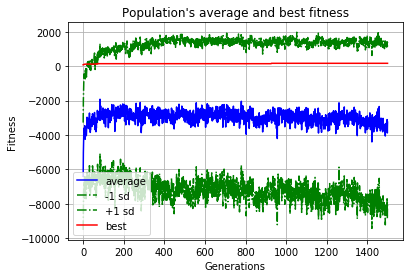

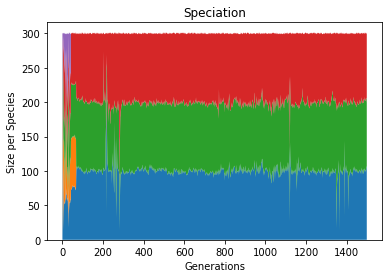

2005-2017 test
Money: 251059.34999999983, Shares: 3, Returns: 166.91%

buy_count: 648, sell_count: 968, hodl_count: 1446

2017-2018 test
Money: 94216.94000000005, Shares: 3, Returns: 10.6%

buy_count: 66, sell_count: 98, hodl_count: 88



In [2]:

"""
NEAT evloving a TraderGenome able to buy/sell/hodl fit for maximum returns
Strategy :  -transform output from ]-1,1[ to ]-5,5[
            -compute the floor of the absolute value of the output and its sign
            -output > 0 then buy or sell (sign -1 sell, sign +1 buy)
            -output = 0 then hodl 
"""

from __future__ import print_function
import os
import neat
import visualize
import csv
import numpy as np
import math

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


# custom gene with buy_count,sell_count and hodl_count
class TraderGenome(neat.DefaultGenome):
    def __init__(self, key):
        super().__init__(key)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def configure_new(self, config):
        super().configure_new(config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def configure_crossover(self, genome1, genome2, config):
        super().configure_crossover(genome1, genome2, config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def mutate(self, config):
        super().mutate(config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def __str__(self):
        return "buy_count: {0}, sell_count: {1}, hodl_count: {2}\n{3}".format(self.buy_count,self.sell_count,self.hodl_count, super().__str__())



# Date, Open, High, Low, Close, Volume
# training data of CAC40 from 2005-06-13 till 2017-06-13
input_training_data = []

# training data of CAC40 from 2017-06-14 till 2018-06-11
input_testing_data = []    
    

def normalize_data(data_array):
    data_norm = []
    minx = min(data_array)
    maxx = max(data_array)
    for data in data_array:
        data_norm.append(2*((data-minx)/(maxx-minx))-1)
    return data_norm, minx, maxx

def load_data_from_csv(filename):
    data = []
    data_open = []
    data_high = []
    data_low = []
    data_close = []
    data_volume = []
    with open(filename, 'r') as File:  
        reader = csv.reader(File)
        for row in reader:
            data.append((round(float(row[1]),2),round(float(row[2]),2),round(float(row[3]),2),round(float(row[4]),2),round(float(row[5]),2)))
            data_open.append(round(float(row[1]),2))
            data_high.append(round(float(row[2]),2))
            data_low.append(round(float(row[3]),2))
            data_close.append(round(float(row[4]),2))
            data_volume.append(round(float(row[5]),2))
    return data, data_open,data_high,data_low,data_close,data_volume
            
    
def combine_arrays(arr1,arr2,arr3,arr4,arr5,):
    index = len(arr1)
    output = []
    for i in range(0,index):
        output.append((arr1[i],arr2[i],arr3[i],arr4[i],arr5[i]))
    return output


input_training_data,input_training_data_open,input_training_data_high,input_training_data_low,input_training_data_close,input_training_data_volume = load_data_from_csv('CAC40_2005_2017.csv')
input_testing_data,input_testing_data_open,input_testing_data_high,input_testing_data_low,input_testing_data_close,input_testing_data_volume = load_data_from_csv('CAC40_2017_2018.csv')


input_training_data_open_norm, input_training_data_open_minx, input_training_data_open_maxx = normalize_data(input_training_data_open)
input_training_data_high_norm, input_training_data_high_minx, input_training_data_high_maxx = normalize_data(input_training_data_high)
input_training_data_low_norm, input_training_data_low_minx, input_training_data_low_maxx = normalize_data(input_training_data_low)
input_training_data_close_norm, input_training_data_close_minx, input_training_data_close_maxx = normalize_data(input_training_data_close)
input_training_data_volume_norm, input_training_data_volume_minx, input_training_data_volume_maxx = normalize_data(input_training_data_volume)


input_testing_data_open_norm, input_testing_data_open_minx, input_testing_data_open_maxx = normalize_data(input_testing_data_open)
input_testing_data_high_norm, input_testing_data_high_minx, input_testing_data_high_maxx = normalize_data(input_testing_data_high)
input_testing_data_low_norm, input_testing_data_low_minx, input_testing_data_low_maxx = normalize_data(input_testing_data_low)
input_testing_data_close_norm, input_testing_data_close_minx, input_testing_data_close_maxx = normalize_data(input_testing_data_close)
input_testing_data_volume_norm, input_testing_data_volume_minx, input_testing_data_volume_maxx = normalize_data(input_testing_data_volume)


    
input_training_data_norm = combine_arrays(input_training_data_open_norm,
                                          input_training_data_high_norm,
                                          input_training_data_low_norm,
                                          input_training_data_close_norm,
                                          input_training_data_volume_norm)

input_testing_data_norm = combine_arrays(input_testing_data_open_norm,
                                          input_testing_data_high_norm,
                                          input_testing_data_low_norm,
                                          input_testing_data_close_norm,
                                          input_testing_data_volume_norm)


# firt output:
#    1 -> buy
#    -1 -> sell
#    0 -> hodl
# second output: share amount to buy/sell
def decide(res):
    res = np.arctanh(res) #denormalizing shares amount ???
    if(np.isinf(res) or np.isnan(res)):
        res = 0
    return np.sign(res), math.floor(abs(res))


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        money = 100000.0
        genome.fitness = 0
        shares = 0
        net = neat.nn.RecurrentNetwork.create(genome, config)
        size = len(input_training_data)
        genome.buy_count = 0
        genome.sell_count = 0
        genome.hodl_count = 0
        for i, input_data in enumerate(input_training_data_norm):
            if (i < size-1):
                input_data = (input_data) + (np.tanh(shares),np.tanh(money),) #shares and capital normalized ???
                output = net.activate(input_data)
                decision, amount = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares >= amount and amount > 0):
                    shares = shares-amount
                    money = money + (amount*input_training_data[i+1][0]) #Sell on market open
                    genome.sell_count = genome.sell_count+1
                
                elif (decision == 1 and money >= (amount*input_training_data[i+1][0]) and amount > 0):
                    shares = shares+amount
                    money = money - (amount*input_training_data[i+1][0]) #Buy on market open
                    genome.buy_count = genome.buy_count+1
                else: 
                    genome.hodl_count = genome.hodl_count+1
                    
        genome.fitness = ((money + shares*input_training_data[-1][0]) - 100000.0)/1000.0 #returns in %
        penality = 2*genome.hodl_count
        if(genome.buy_count == 0 or genome.sell_count == 0):
            genome.fitness = genome.fitness - penality
        if(genome.hodl_count > genome.sell_count + genome.buy_count):
            op_sum = genome.sell_count + genome.buy_count
            if (op_sum != 0):
                penality == 30*genome.hodl_count/op_sum

            genome.fitness -= math.floor(penality)


                
#EXECUSTION            
local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-tradergenome')
# Load configuration.
config = neat.Config(TraderGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(10))

# Run for up to X generations.
winner = p.run(eval_genomes, 1500)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

print('\nOutput:')
winner_net = neat.nn.RecurrentNetwork.create(winner, config)

node_names = {-1:'Open', -2: 'High',-3: 'Low',-4: 'Close',-5: 'Volume',-6: 'Shares',-7: 'Money', 0:'Decide'}
visualize.draw_net(config, winner, True, node_names=node_names)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

"""
Testing best TraderGenome 2017-2018
"""

def test_best(input_test,input_test_norm):
    capital = 100000.0
    shares = 0
    size = len(input_test)
    buy_count = 0
    sell_count = 0
    hodl_count = 0
    for i, input_data in enumerate(input_test_norm):
        if (i < size-1):
                input_data = (input_data) + (np.tanh(shares),np.tanh(capital),) #shares and capital normalized ???
                output = winner_net.activate(input_data)
                decision, amount = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares >= amount and amount > 0):
                    shares = shares-amount
                    capital = capital + (amount*input_test[i+1][0]) #Sell on market open
                    sell_count = sell_count+1

                elif (decision == 1 and capital >= (amount*input_test[i+1][0]) and amount > 0):
                    shares = shares+amount
                    capital = capital - (amount*input_test[i+1][0]) #Buy on market open
                    buy_count = buy_count+1
                else: 
                    hodl_count = hodl_count+1
    print('Money: {!r}, Shares: {!r}, Returns: {!r}%\n'.format(capital,shares, round(((capital+shares*input_test[-1][0])-100000.0)/1000.0,2)))
    print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))        



"""
Testing TraderGenome 2005-2017
"""
print('2005-2017 test')
test_best(input_training_data,input_training_data_norm)


"""
Testing TraderGenome 2017-2018
"""
print('2017-2018 test')
test_best(input_testing_data,input_testing_data_norm)


"""
Testing TraderGenome 2005-2018
"""

input_testing_data_norm_full = input_training_data_norm + input_testing_data_norm

input_testing_data_full = input_training_data + input_testing_data

#print('2005-2018 test')
#test_best(input_testing_data_full,input_testing_data_norm_full)


In [43]:
"""
Testing TraderGenome 2005-2017
"""

def test_best(input_test,input_test_norm):
    capital = 100000.0
    shares = 0
    size = len(input_test)
    buy_count = 0
    sell_count = 0
    hodl_count = 0
    print('testing')
    for i, input_data in enumerate(input_test_norm):
        if (i < size-1):
                input_data = (input_data) + (np.tanh(shares),np.tanh(capital),) #shares and capital normalized ???
                output = winner_net.activate(input_data)
                decision, amount = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares >= amount and amount > 0):
                    shares = shares-amount
                    capital = capital + (amount*input_test[i+1][0]) #Sell on market open
                    sell_count = sell_count+1

                elif (decision == 1 and capital >= (amount*input_test[i+1][0]) and amount > 0):
                    shares = shares+amount
                    capital = capital - (amount*input_test[i+1][0]) #Buy on market open
                    buy_count = buy_count+1
                else: 
                    hodl_count = hodl_count+1
    print('Money: {!r}, Shares: {!r}, Returns: {!r}%\n'.format(capital,shares, ((capital+shares*input_test[-1][0])-100000.0)/1000.0))
    print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))        

print('2005-2017 test')
test_best(input_training_data,input_training_data_norm)

print('2017-2018 test')
test_best(input_testing_data,input_testing_data_norm)





2005-2017 test
testing
Money: 154415.0699999999, Shares: 0, Returns: 54.41506999999989%

buy_count: 881, sell_count: 892, hodl_count: 1289

2005-2017 test
testing
Money: 154415.0699999999, Shares: 0, Returns: 54.41506999999989%

buy_count: 881, sell_count: 892, hodl_count: 1289

2017-2018 test
testing
Money: 90604.27000000002, Shares: 3, Returns: 6.983700000000011%

buy_count: 26, sell_count: 27, hodl_count: 199



c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in arctanh
